In [23]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
np.set_printoptions(precision=3)

In [32]:
def mem_stack(seq, fpath, mem_type='mem'):
    seq_len = len(seq)
    mem = {i:[] for i in range(seq_len)}
    i = 0
    nc = 0
    nt = 0
    with open(fpath, 'r') as f:
        for line in f:
            line_json = json.loads(line)
            if line_json['type'] != 'actions':
                assert line_json['type'] == 'input'
                nc += line_json['is_correct']
                nt += 1
                continue 
                
            mem[i].append(line_json[mem_type])        
            i += 1
            i %= seq_len
    print('correct prediction%:', nc/nt)
    remain = 3
    step = []
    for i in range(seq_len):
        step.append(np.array(mem[i]))
    mean_mem_dist = []
    for i in range(seq_len):
        mean_mem_dist.append((step[i].sum(0)/step[i].shape[0])[:, :remain])
    for i in range(seq_len):
        mean_mem_dist[i] = np.hstack([mean_mem_dist[i], np.ones((5, 1))])
#         mean_mem_dist[i] = np.hstack([mean_mem_dist[i], np.zeros((5, 1))])
    mem_whole = np.hstack(mean_mem_dist)
    mem_whole.shape
    ncols = mem_whole.shape[1]
    
    step_img = seq_len // 4 * (remain+1)
    step_txt = seq_len // 4

    for i in range(4):
        fig, ax = plt.subplots()
        fig.dpi = 200
        start_img = i * step_img
        end_img = (i+1) * step_img
        start_txt = i * step_txt
        end_txt = (i+1) * step_txt
        mem = mem_whole[:, start_img:end_img-1]
        plt.imshow(mem, cmap=plt.cm.Blues, vmax=0.7)
#         plt.imshow(mem, cmap=plt.cm.hot, vmax=0.7)
    #     print(start_txt, end_txt)
    #     print(np.arange(1, end_img-start_img+1, 4), list(seq)[start_txt:end_txt])
        plt.xticks(np.arange(1, end_img-start_img+1, 4), list(seq)[start_txt:end_txt], fontsize=8)
        plt.yticks(np.arange(5), fontsize=8)
        if i == 0:
            xlbl_str = 'input symbol (the 1st part)'
        elif i == 1:
            xlbl_str = 'input symbol (the 2nd part)'
        elif i == 2:
            xlbl_str = 'input symbol (the 3rd part)'
        else:
            xlbl_str = 'input symbol (the 4th part)'

        plt.xlabel(xlbl_str, fontsize=8)
        plt.ylabel('')
        plt.show()

correct prediction%: 0.992


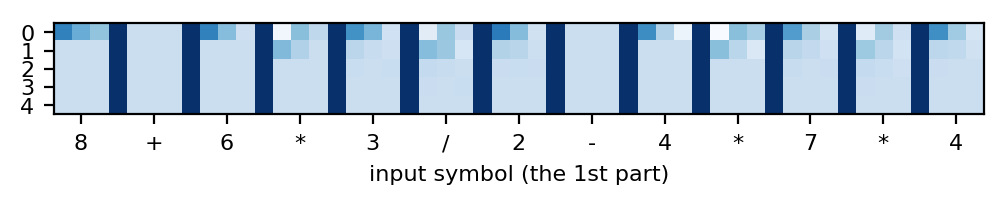

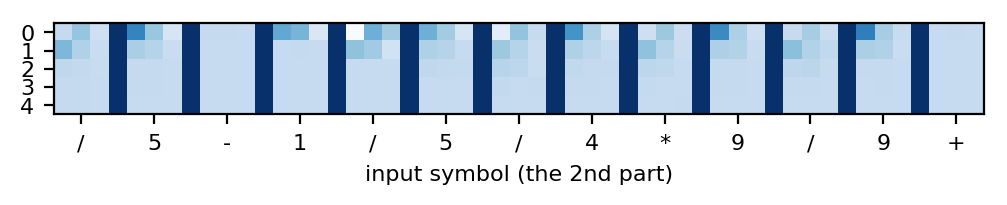

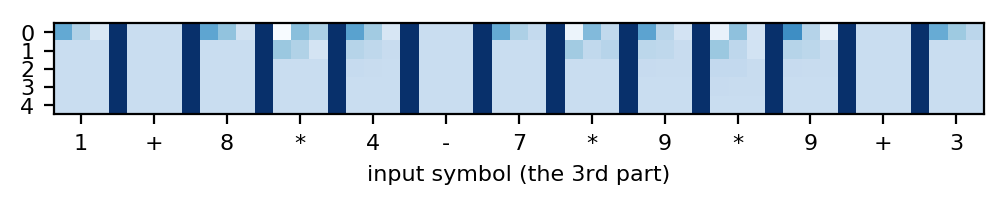

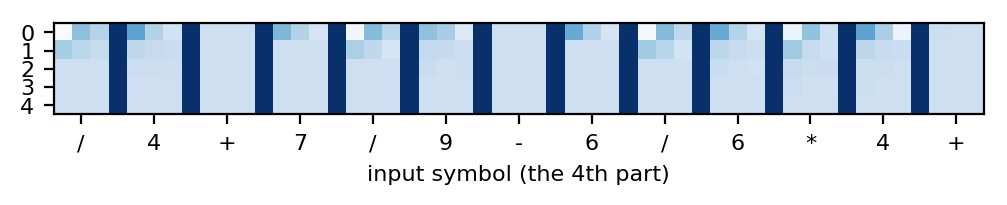

In [3]:
seq = '8 + 6 * 3 / 2 - 4 * 7 * 4 / 5 - 1 / 5 / 4 * 9 / 9 + 1 + 8 * 4 - 7 * 9 * 9 + 3 / 4 + 7 / 9 - 6 / 6 * 4 + 3 / 3'.split(' ')
ds = '1 5 1 2 3 4 6 7 1 2 3 4 5 6 8 9 1 2 3 4 5 6 7 8 10 11 12 13 1 2 14 15 1 2 3 4 16 17 1 2 18 19 1 2 20 21 1 2 3 4 22 23 1 2'.split(' ')
syn_dis = [int(d) for d in ds]
fpath = 'feval-analy_d23_ne10-sarnn.txt'
# fpath = 'feval-analy_d23_ne10-sarnn-1544164689.txt'
# fpath = 'feval-analy_d23_ne10-sarnn-1544171304.txt'
mem_stack(seq, fpath, 'mem')

In [25]:
def policy_stack(seq, sd, fpath):
    seq_len = len(seq)
    syn_dis = [int(d) for d in sd]
    prob_action = {i:[] for i in range(seq_len)}
    i = 0
    nc = 0
    nt = 0
    with open(fpath, 'r') as f:
        for line in f:
            line_json = json.loads(line)
            if line_json['type'] != 'actions':
                assert line_json['type'] == 'input'
                nc += line_json['is_correct']
                nt += 1
                continue 

            prob_action[i].append(line_json['all'])
            i += 1
            i %= seq_len   
        
    step = []
    for i in range(seq_len):
        step.append(np.array(prob_action[i]))
    mean_dist = []
    for i in range(seq_len):
        mean_dist.append(step[i].sum(0)/step[i].shape[0])
    push = [mean_dist[t][:6].sum() for t in range(seq_len)]
    npop = []
    for t in range(seq_len):
        pop = (mean_dist[t][:6] * np.arange(6)).sum() + \
            (mean_dist[t][6:] * np.arange(6)).sum()
        npop.append(pop)    
    npop = []
    for t in range(seq_len):
        pop = (mean_dist[t][:6] * np.arange(6)).sum() + \
            (mean_dist[t][6:] * np.arange(6)).sum()
        npop.append(pop)    

    kept = 27
    fig, ax = plt.subplots()
    fig.dpi = 200
    plt.grid(axis='both', linestyle='dashed', linewidth=0.5)
    lns0 = ax.bar(np.arange(0.5, seq_len-0.5)[:kept-1], (np.array(syn_dis)/max(syn_dis))[:kept-1]*0.3,
            label='syn-distance', color='gray')

    lns1 = ax.plot(np.arange(seq_len)[:kept], 
             push[:kept],
            label='push', marker='s',color='blue', alpha=0.5, fillstyle='none')
    ax.set_ylabel('Push probabiliy', fontsize=15)
    ax.set_yticks(np.arange(0, 1+0.1, 0.1))
    ax.set_xlabel('input symbol', fontsize=15)
    
    ax_r = ax.twinx()
    lns2 = ax_r.plot(np.arange(seq_len)[:kept], 
             npop[:kept],
            label='pop', marker='o', color='red', alpha=0.5, fillstyle='none')
    ax_r.set_ylabel('Expectation of #pop', fontsize=15)
    ax_r.set_yticks(np.arange(0, 5+1, 1))

    lns = [lns0] + lns1 + lns2
    labs = [l.get_label() for l in lns]
    plt.legend(lns, labs, loc=0, fontsize=10)

#     plt.xlabel('input symbol')

    #     plt.legend()
    plt.xticks(np.arange(0, seq_len, 1)[:kept], list(seq)[:kept], fontsize=15)
    # plt.yticks(np.arange(0, 1.1, 0.1), fontsize=10)
    plt.show()

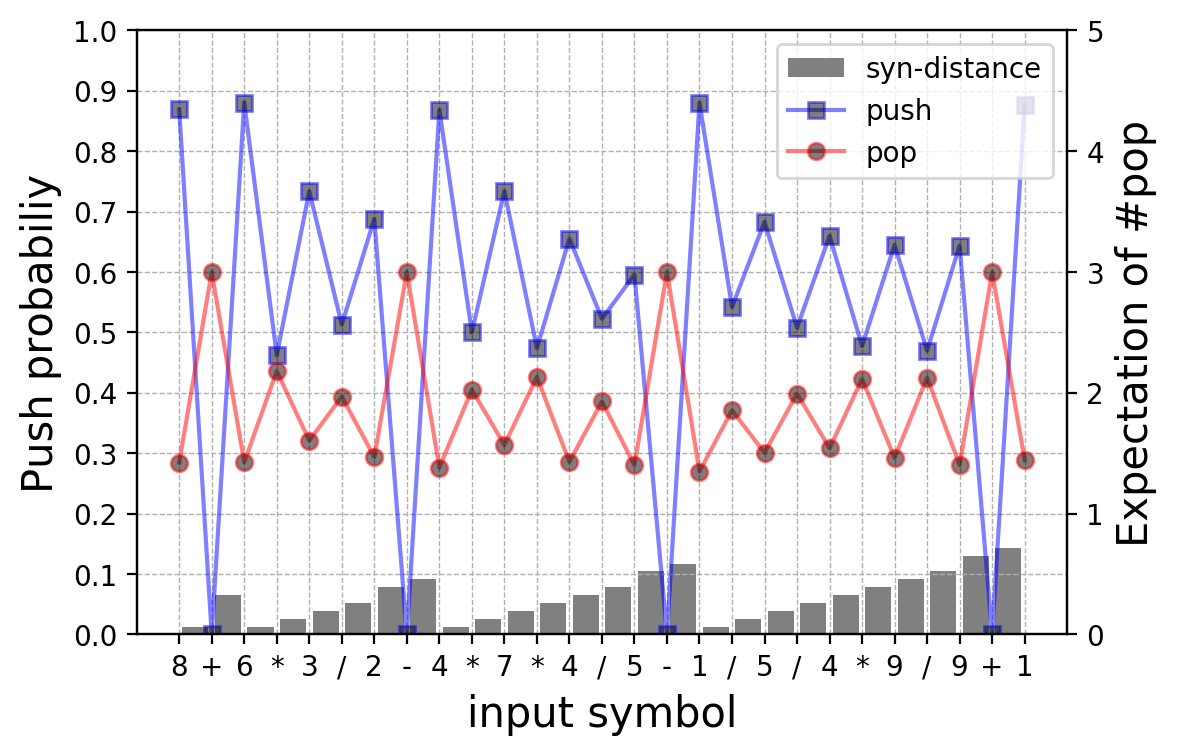

In [22]:
policy_stack(seq, syn_dis, fpath)

In [26]:
def to_value_sd(sd_lst, node_lst):
    if len(sd_lst) == 0:
        node = node_lst[0]
        v = node
    else:
        i = np.argmax(sd_lst)
        child_l, v_l = to_value_sd(sd_lst[:i], node_lst[:i+1])
        child_r, v_r = to_value_sd(sd_lst[i+1:], node_lst[i+1:])
        node = (child_l, child_r)
        if isinstance(v_l, tuple) and not isinstance(v_r, tuple):
            v1, op = v_l[0], v_l[1]
            v2 = v_r
            if op == '/':
                v = str(int(v1) % int(v2))
            else:
                v = str(eval(''.join([v1, op, v2])) % 10)
        else:
            assert not isinstance(v_l, tuple) and not isinstance(v_r, tuple)
            v = (v_l, v_r)

    return node, v

In [27]:
def cluster_on(seq, syn_dis, fpath, mem_type, t, cell_begin, cell_end, term_begin, term_end):
    seq_len = len(seq)
    print_num = 5
    printed = 0
    mem = {i:[] for i in range(seq_len)}
    vals = []
    exprs = []
    i = 0
    nc = 0
    nt = 0
    cidx = 0
    
    colors = {
        '0': 'r',
        '1': 'orange',
        '2': 'gold',
        '3': 'tan',
        '4': 'seagreen',
        '5': 'b',
        '6': 'purple',
        '7': 'brown',
        '8': 'hotpink',
        '9': 'silver',
        '*': 'orange',
        '/': 'orchid'}
    
    with open(fpath, 'r') as f:
        for line in f:
            line_json = json.loads(line)
            if line_json['type'] != 'actions':
                assert line_json['type'] == 'input'
                nc += line_json['is_correct']
                nt += 1
                
                node_lst = line_json['expr'][term_begin: term_end]
                ds = syn_dis[term_begin: term_end-1]
                exprs.append(line_json['expr'])
                try:
                    eval(''.join(node_lst))
                    val = to_value_sd(ds, node_lst)[1] 
                except:
                    val = to_value_sd(ds[:-1], node_lst[:-1])[1] 
                    val = ''.join([str(val), node_lst[-1]])
                    
                if printed < print_num:
                    print(node_lst, ds, val)
                    printed += 1
                
                vals.append(val)
                continue 
            mem[i].append(line_json[mem_type])        
            i += 1
            i %= seq_len

    X = np.array([np.array(mem[t][i][cell_begin: cell_end]).reshape(-1)  
                  for i in range(len(mem[t]))])
    print(X[:printed, :10])
    
    X_embedded = TSNE(n_components=2).fit_transform(X)
    x_min, x_max = X_embedded.min(0) - 5, X_embedded.max(0) + 5 
    X_norm = (X_embedded - x_min) / (x_max - x_min)  # 归一化
    plt.figure(figsize=(10, 10))
    for i in range(X_norm.shape[0]):
        if not str(vals[i]) in colors:
#             cidx = np.random.rand()
            R = np.random.rand()
            G = np.random.rand()
            B = np.random.rand()
            colors[vals[i]] = (R, G, B, 0.5)
#             colors[vals[i]] = plt.cm.Set1(cidx)
#             cidx += 0.07
#             if cidx > 1:
#                 cidx = 0
        plt.text(X_norm[i, 0], X_norm[i, 1], str(vals[i]), color=colors[str(vals[i])], 
                 fontdict={'weight': 'bold', 'size': 25})
        
    ax = plt.gca() # 获取当前的axes
    ax.spines['top'].set_visible(False) #去掉右边框
    ax.spines['right'].set_visible(False) #去掉右边框
    plt.xticks(np.arange(0,1.2,0.2), [])
    plt.yticks(np.arange(0,1.2,0.2), [])
    plt.show()

In [28]:
plt.cm.Set1(0.1)

(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0)

In [29]:
np.random.rand()

0.4787520009328632

correct prediction%: 0.992


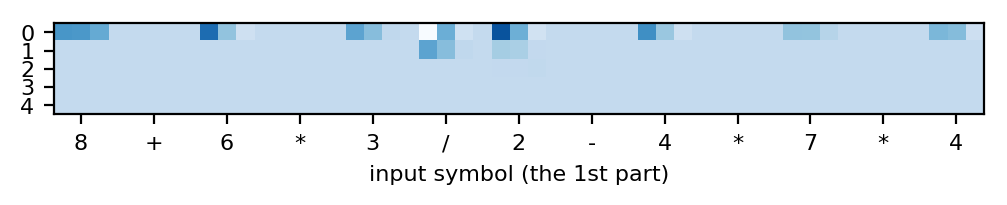

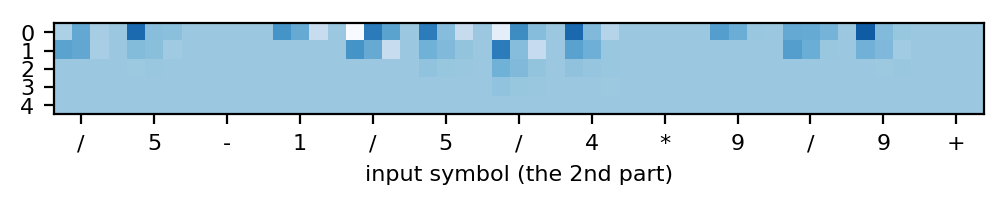

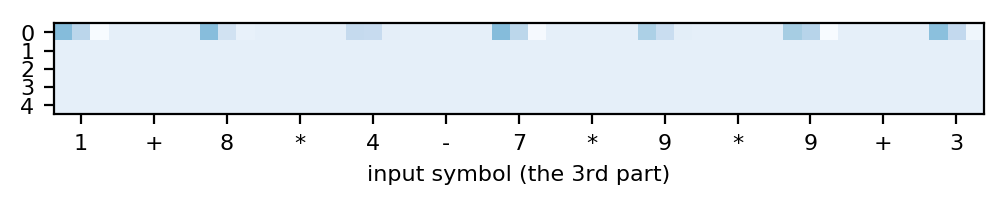

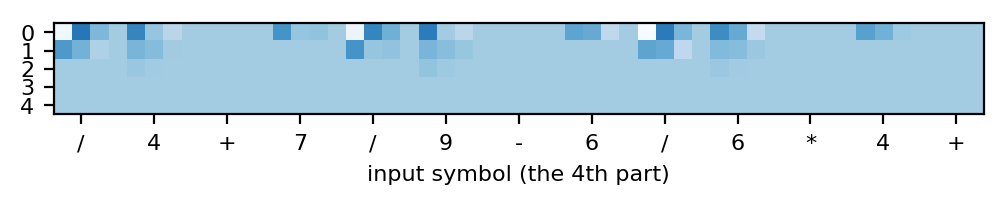

In [33]:
seq = '8 + 6 * 3 / 2 - 4 * 7 * 4 / 5 - 1 / 5 / 4 * 9 / 9 + 1 + 8 * 4 - 7 * 9 * 9 + 3 / 4 + 7 / 9 - 6 / 6 * 4 + 3 / 3'.split(' ')
ds = '1 5 1 2 3 4 6 7 1 2 3 4 5 6 8 9 1 2 3 4 5 6 7 8 10 11 12 13 1 2 14 15 1 2 3 4 16 17 1 2 18 19 1 2 20 21 1 2 3 4 22 23 1 2'.split(' ')
syn_dis = [int(d) for d in ds]
fpath = 'feval-change_numerals-sarnn-1544628893.txt'
mem_stack(seq, fpath, 'mem')

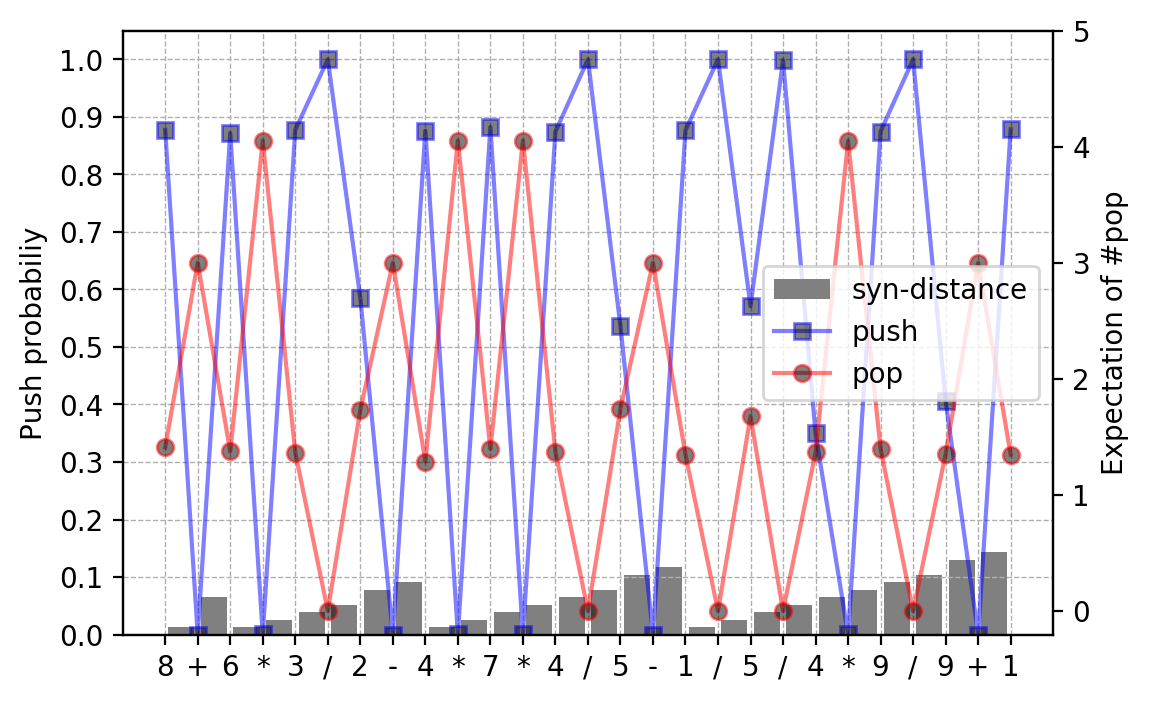

In [8]:
policy_stack(seq, syn_dis, fpath)

['5', '*'] [1] 5*
['4', '*'] [1] 4*
['1', '*'] [1] 1*
['3', '*'] [1] 3*
['9', '*'] [1] 9*
[[ 2.557e-04  3.101e-04  1.518e-04 -2.075e-04  2.680e-04  1.091e-05
  -2.241e-06 -3.932e-04 -1.524e-04 -4.848e-05]
 [ 3.673e-04  1.357e-04 -3.156e-05  2.761e-04  5.356e-04  2.981e-04
  -1.992e-04  8.525e-04  2.689e-04 -2.246e-04]
 [-5.086e-04  2.281e-04  1.775e-04 -9.430e-05  5.685e-06  3.111e-04
   1.567e-04 -4.057e-04  8.532e-05  1.195e-04]
 [-6.900e-06  4.130e-04  3.526e-04 -5.306e-05  6.969e-04  1.094e-05
  -4.602e-05 -1.431e-04  3.496e-04 -4.828e-04]
 [ 6.266e-04  2.729e-04  1.931e-04 -3.730e-04  2.625e-04 -3.793e-04
  -5.247e-04 -2.536e-04  3.066e-04 -1.118e-04]]


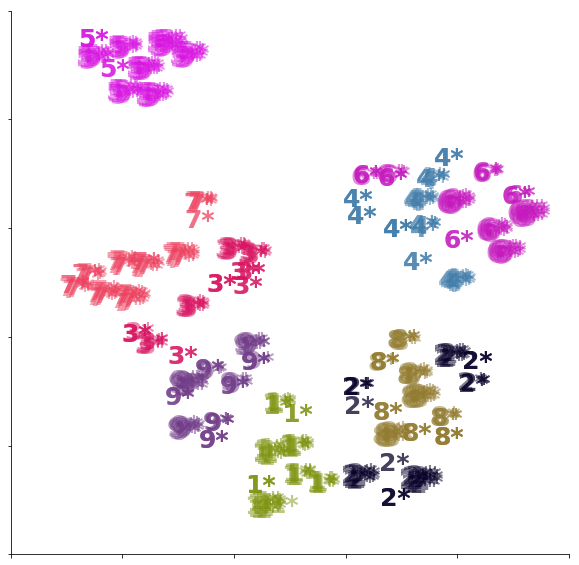

In [9]:
cluster_on(seq, syn_dis, fpath, 'mem', 3, 0, 0+1, 2, 3+1)

['1', '/', '1', '*'] [1, 2, 3] 0*
['5', '*', '6', '/'] [1, 2, 3] 0/
['6', '*', '5', '*'] [1, 2, 3] 0*
['8', '/', '1', '*'] [1, 2, 3] 0*
['7', '*', '9', '*'] [1, 2, 3] 3*
[[ 5.920e-04  3.080e-04 -5.115e-04  9.646e-05 -4.784e-04 -1.279e-04
  -3.501e-04 -2.847e-05 -3.161e-04  2.597e-04]
 [ 1.167e+00  2.826e-01 -3.672e-01 -9.767e-01 -9.602e-01 -2.601e+00
  -4.457e-01 -7.793e-01 -8.159e-01  2.671e+00]
 [ 2.231e-04 -2.010e-04 -4.006e-05  1.456e-04 -8.226e-05  1.077e-04
   1.082e-04 -1.040e-04  1.868e-04  1.130e-04]
 [ 2.466e-04 -1.302e-04 -2.851e-04  7.449e-05 -5.045e-04  5.284e-05
   6.652e-05 -4.844e-05  1.544e-04  1.736e-04]
 [ 3.548e-05  4.494e-04  3.147e-04  9.817e-05  5.191e-04 -6.411e-05
  -6.717e-05 -7.846e-05  2.419e-04 -6.232e-04]]


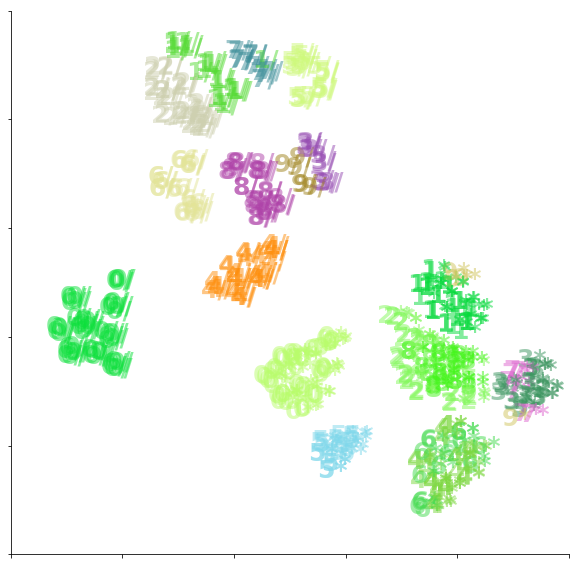

In [30]:
cluster_on(seq, syn_dis, fpath, 'mem', 5, 0, 0+1, 2, 5+1)

['1', '+', '5', '*', '2'] [1, 5, 1, 2] 1
['1', '+', '4', '*', '9'] [1, 5, 1, 2] 7
['8', '+', '1', '*', '3'] [1, 5, 1, 2] 1
['3', '+', '3', '*', '2'] [1, 5, 1, 2] 9
['5', '+', '9', '*', '5'] [1, 5, 1, 2] 0
[[ 0.933  0.84  -0.77   0.203 -0.146  0.864 -1.321 -1.002 -0.404  1.366]
 [ 0.877  0.138  0.059  0.898  0.702 -0.187  1.608  1.88   0.717 -0.327]
 [-0.8    0.81  -0.362  0.59   0.029  0.443 -0.96  -0.544 -0.486 -1.459]
 [ 0.222  1.327 -1.183  1.7   -0.051  0.217  0.048  1.371  0.275 -0.13 ]
 [ 1.65  -0.595 -1.236 -0.294 -1.201 -1.803  0.453 -1.068 -0.473 -1.024]]


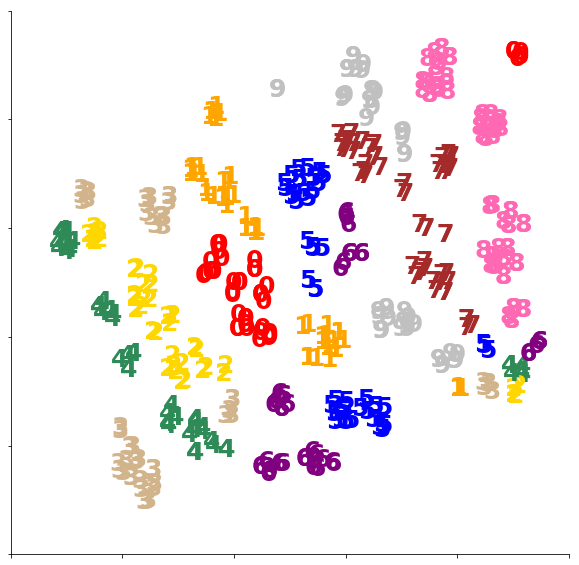

In [10]:
cluster_on(seq, syn_dis, fpath, 'mem', 4, 0, 0+1, 0, 4+1)

['1', '+', '5', '*', '2', '/', '9'] [1, 5, 1, 2, 3, 4] 1
['1', '+', '4', '*', '9', '/', '3'] [1, 5, 1, 2, 3, 4] 1
['8', '+', '1', '*', '3', '/', '4'] [1, 5, 1, 2, 3, 4] 1
['3', '+', '3', '*', '2', '/', '4'] [1, 5, 1, 2, 3, 4] 5
['5', '+', '9', '*', '5', '/', '2'] [1, 5, 1, 2, 3, 4] 6
[[ 0.933  0.838 -0.771  0.204 -0.146  0.861 -1.319 -1.    -0.406  1.367]
 [ 0.252  0.75  -0.518  0.794 -0.338  0.153 -0.62  -1.327 -1.425  1.033]
 [-0.793  0.795 -0.359  0.596  0.027  0.441 -0.959 -0.55  -0.472 -1.454]
 [-0.097 -0.112  1.096  0.045  1.679  0.911  0.543 -1.53   1.309  1.253]
 [ 1.108  1.235  0.124 -1.059 -0.943 -1.465  0.742 -2.157  0.492  1.546]]


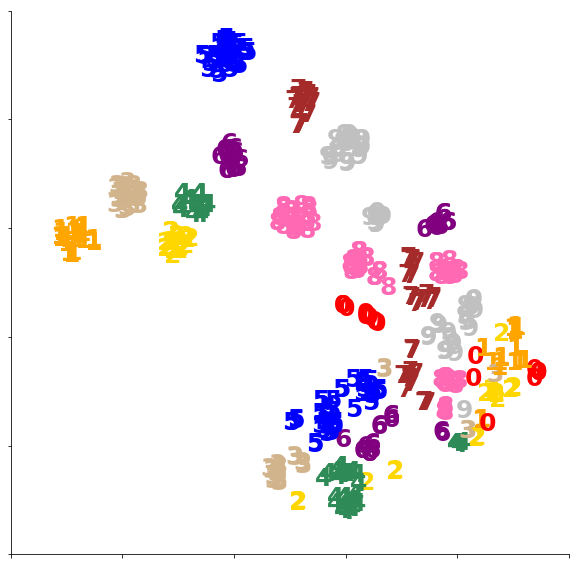

In [11]:
cluster_on(seq, syn_dis, fpath, 'mem', 6, 0, 0+1, 0, 6+1)

['1', '+', '5', '*', '2', '/', '9', '-', '6', '*', '9', '*', '5', '/', '7', '-', '3', '/', '1', '/', '8', '*', '1', '/', '9', '+', '3', '+', '5', '*', '4', '-', '5', '*', '5', '*', '6', '+', '1', '/', '1', '+', '9', '/', '9', '-', '8', '/', '2', '*', '2', '+', '5', '/', '7'] [1, 5, 1, 2, 3, 4, 6, 7, 1, 2, 3, 4, 5, 6, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 1, 2, 14, 15, 1, 2, 3, 4, 16, 17, 1, 2, 18, 19, 1, 2, 20, 21, 1, 2, 3, 4, 22, 23, 1, 2] 9
['1', '+', '4', '*', '9', '/', '3', '-', '3', '*', '3', '*', '6', '/', '9', '-', '9', '/', '8', '/', '4', '*', '9', '/', '7', '+', '9', '+', '1', '*', '9', '-', '4', '*', '4', '*', '4', '+', '7', '/', '4', '+', '3', '/', '5', '-', '1', '/', '4', '*', '4', '+', '2', '/', '9'] [1, 5, 1, 2, 3, 4, 6, 7, 1, 2, 3, 4, 5, 6, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 1, 2, 14, 15, 1, 2, 3, 4, 16, 17, 1, 2, 18, 19, 1, 2, 20, 21, 1, 2, 3, 4, 22, 23, 1, 2] 3
['8', '+', '1', '*', '3', '/', '4', '-', '6', '*', '9', '*', '5', '/', '8', '-', '5', '/',

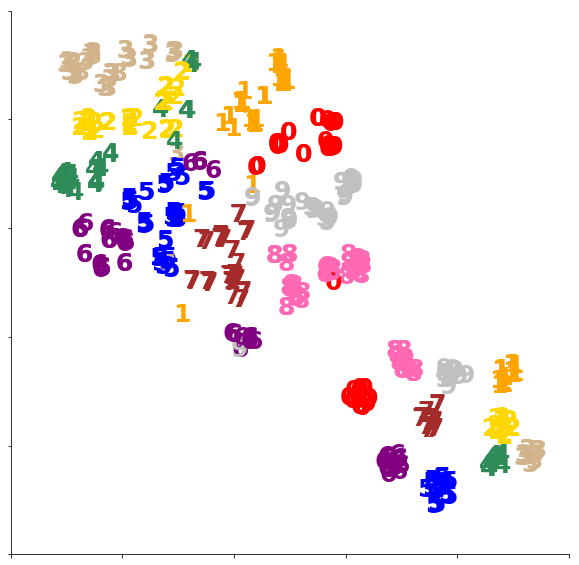

In [20]:
cluster_on(seq, syn_dis, fpath, 'mem', 54, 0, 0+1, 0, 54+1)

['1', '+', '5', '*', '2', '/', '9', '-', '6', '*', '9', '*', '5', '/', '7', '-', '3', '/', '1', '/', '8', '*', '1', '/', '9', '+', '3', '+', '5', '*', '4', '-', '5', '*', '5', '*', '6', '+', '1', '/', '1', '+', '9', '/', '9', '-', '8', '/', '2', '*', '2'] [1, 5, 1, 2, 3, 4, 6, 7, 1, 2, 3, 4, 5, 6, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 1, 2, 14, 15, 1, 2, 3, 4, 16, 17, 1, 2, 18, 19, 1, 2, 20, 21, 1, 2, 3, 4] 4
['1', '+', '4', '*', '9', '/', '3', '-', '3', '*', '3', '*', '6', '/', '9', '-', '9', '/', '8', '/', '4', '*', '9', '/', '7', '+', '9', '+', '1', '*', '9', '-', '4', '*', '4', '*', '4', '+', '7', '/', '4', '+', '3', '/', '5', '-', '1', '/', '4', '*', '4'] [1, 5, 1, 2, 3, 4, 6, 7, 1, 2, 3, 4, 5, 6, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 1, 2, 14, 15, 1, 2, 3, 4, 16, 17, 1, 2, 18, 19, 1, 2, 20, 21, 1, 2, 3, 4] 1
['8', '+', '1', '*', '3', '/', '4', '-', '6', '*', '9', '*', '5', '/', '8', '-', '5', '/', '4', '/', '4', '*', '6', '/', '9', '+', '5', '+', '5', '*', '7', '-

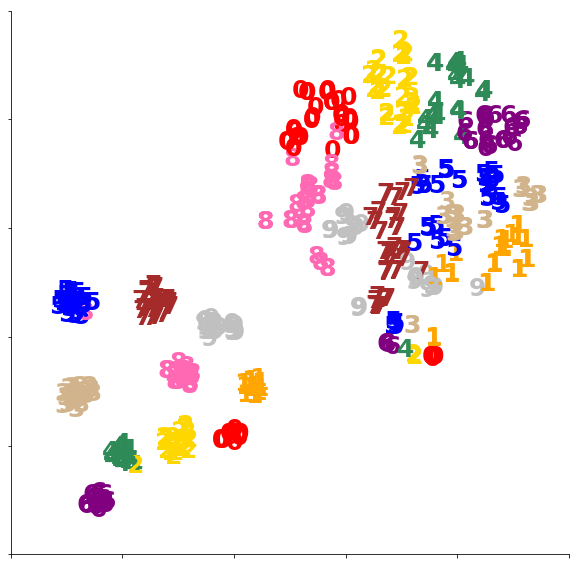

In [22]:
cluster_on(seq, syn_dis, fpath, 'mem', 50, 0, 0+1, 0, 50+1)

['1', '+', '5', '*', '2', '/', '9', '-', '6', '*', '9', '*', '5', '/', '7', '-', '3', '/', '1', '/', '8', '*', '1', '/', '9', '+', '3', '+', '5', '*', '4', '-', '5', '*', '5', '*', '6', '+', '1', '/', '1', '+', '9', '/', '9', '-', '8', '/', '2'] [1, 5, 1, 2, 3, 4, 6, 7, 1, 2, 3, 4, 5, 6, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 1, 2, 14, 15, 1, 2, 3, 4, 16, 17, 1, 2, 18, 19, 1, 2, 20, 21, 1, 2] 4
['1', '+', '4', '*', '9', '/', '3', '-', '3', '*', '3', '*', '6', '/', '9', '-', '9', '/', '8', '/', '4', '*', '9', '/', '7', '+', '9', '+', '1', '*', '9', '-', '4', '*', '4', '*', '4', '+', '7', '/', '4', '+', '3', '/', '5', '-', '1', '/', '4'] [1, 5, 1, 2, 3, 4, 6, 7, 1, 2, 3, 4, 5, 6, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 1, 2, 14, 15, 1, 2, 3, 4, 16, 17, 1, 2, 18, 19, 1, 2, 20, 21, 1, 2] 4
['8', '+', '1', '*', '3', '/', '4', '-', '6', '*', '9', '*', '5', '/', '8', '-', '5', '/', '4', '/', '4', '*', '6', '/', '9', '+', '5', '+', '5', '*', '7', '-', '4', '*', '4', '*', '1', '+',

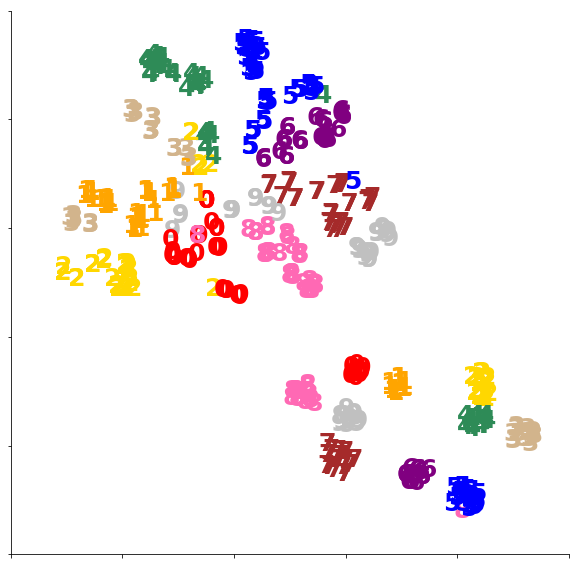

In [23]:
cluster_on(seq, syn_dis, fpath, 'mem', 48, 0, 0+1, 0, 48+1)

['1', '+', '5', '*', '2', '/', '9', '-', '6', '*', '9', '*', '5', '/', '7'] [1, 5, 1, 2, 3, 4, 6, 7, 1, 2, 3, 4, 5, 6] 1
['1', '+', '4', '*', '9', '/', '3', '-', '3', '*', '3', '*', '6', '/', '9'] [1, 5, 1, 2, 3, 4, 6, 7, 1, 2, 3, 4, 5, 6] 7
['8', '+', '1', '*', '3', '/', '4', '-', '6', '*', '9', '*', '5', '/', '8'] [1, 5, 1, 2, 3, 4, 6, 7, 1, 2, 3, 4, 5, 6] 1
['3', '+', '3', '*', '2', '/', '4', '-', '9', '*', '3', '*', '1', '/', '7'] [1, 5, 1, 2, 3, 4, 6, 7, 1, 2, 3, 4, 5, 6] 5
['5', '+', '9', '*', '5', '/', '2', '-', '2', '*', '9', '*', '4', '/', '9'] [1, 5, 1, 2, 3, 4, 6, 7, 1, 2, 3, 4, 5, 6] 4
[[ 1.336  0.9   -1.099  0.134 -0.542 -0.064 -0.943  0.06  -1.02   1.833]
 [ 0.595 -0.159  0.184  0.377  0.532 -0.924  0.812  0.708  0.831 -0.308]
 [ 1.307  0.763 -1.232  0.296 -0.684 -0.128 -1.019  0.237 -1.125  1.888]
 [-0.215  1.792  0.643 -0.966 -1.534 -1.222 -0.623 -1.157 -0.87   1.327]
 [-0.961 -0.103  1.18  -0.847 -0.441 -0.744  0.384 -0.786 -0.473  1.482]]


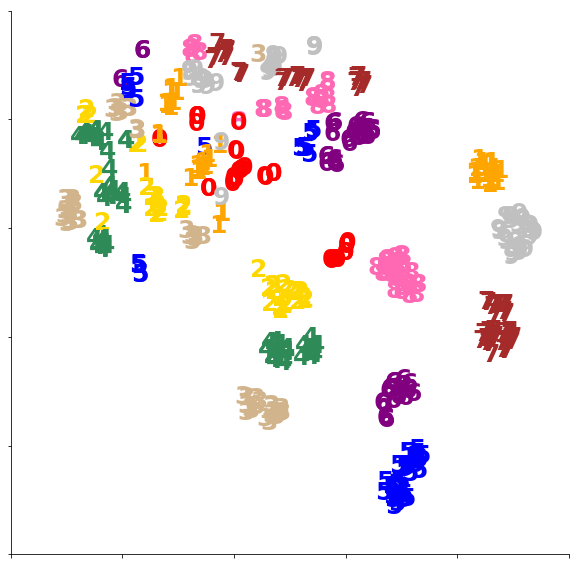

In [25]:
cluster_on(seq, syn_dis, fpath, 'mem', 14, 0, 0+1, 0, 14+1)

correct prediction%: 0.992


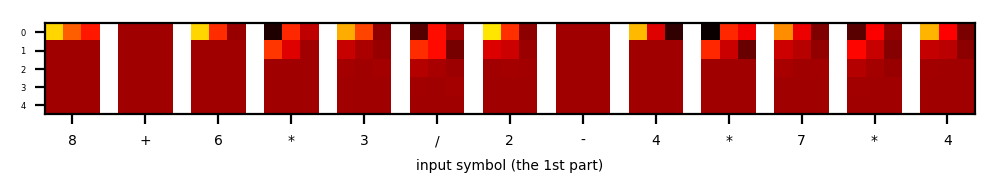

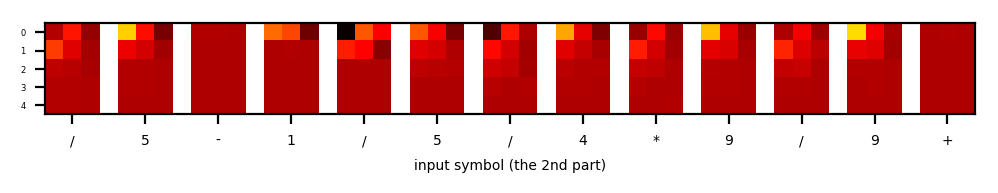

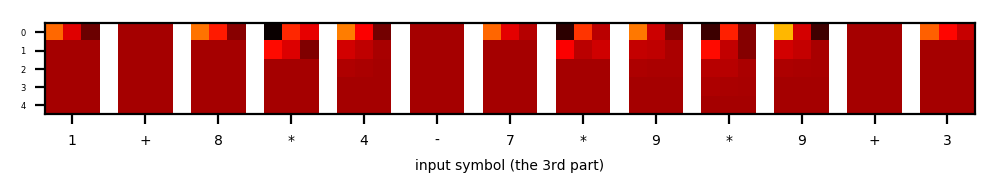

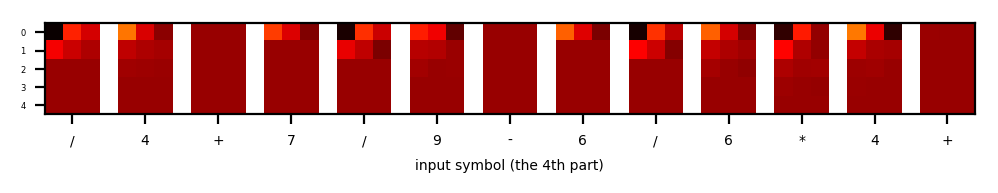

In [29]:
seq = '8 + 6 * 3 / 2 - 4 * 7 * 4 / 5 - 1 / 5 / 4 * 9 / 9 + 1 + 8 * 4 - 7 * 9 * 9 + 3 / 4 + 7 / 9 - 6 / 6 * 4 + 3 / 3'.split(' ')
ds = '1 5 1 2 3 4 6 7 1 2 3 4 5 6 8 9 1 2 3 4 5 6 7 8 10 11 12 13 1 2 14 15 1 2 3 4 16 17 1 2 18 19 1 2 20 21 1 2 3 4 22 23 1 2'.split(' ')
syn_dis = [int(d) for d in ds]
fpath = 'feval-analy_d23_ne10-sarnn.txt'
# fpath = 'feval-analy_d23_ne10-sarnn-1544164689.txt'
# fpath = 'feval-analy_d23_ne10-sarnn-1544171304.txt'
mem_stack(seq, fpath, 'mem')

correct prediction%: 0.992


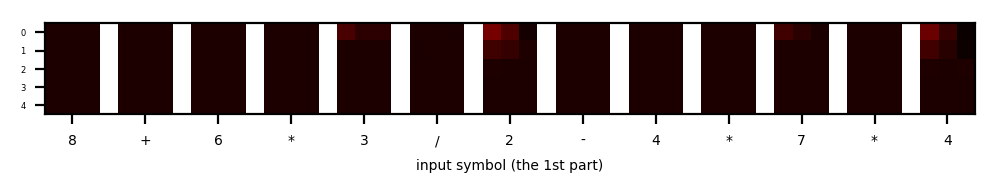

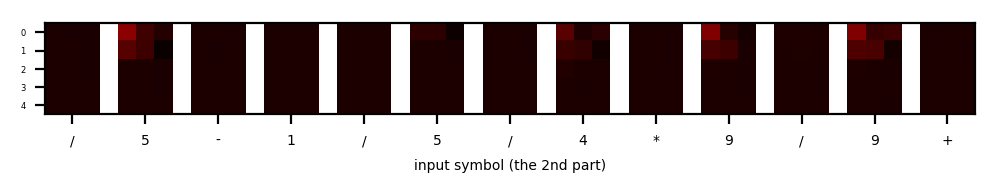

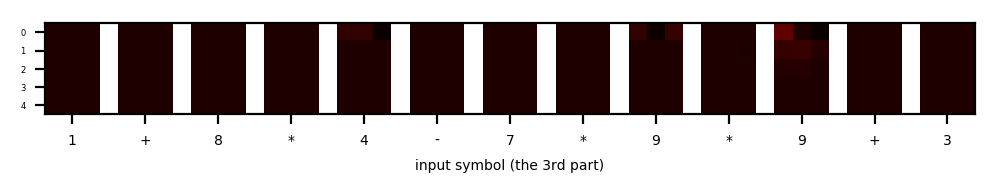

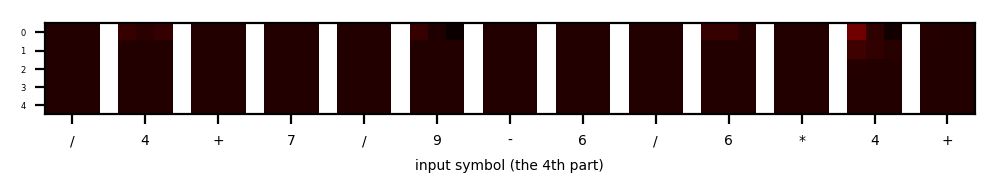

In [29]:
mem_stack(seq, fpath, 'mem_stay')

correct prediction%: 0.992


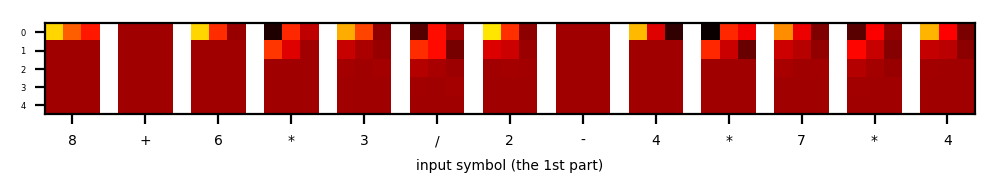

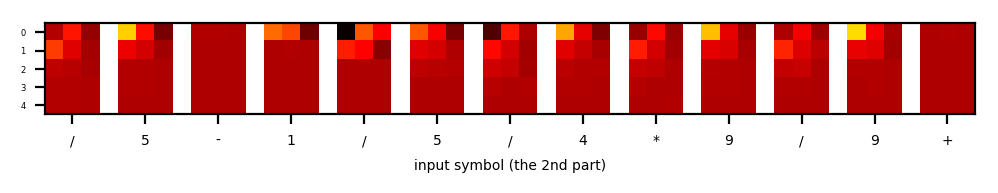

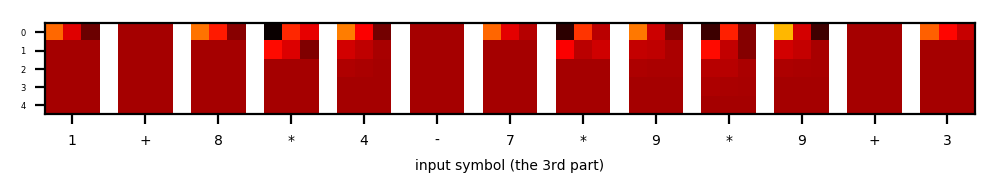

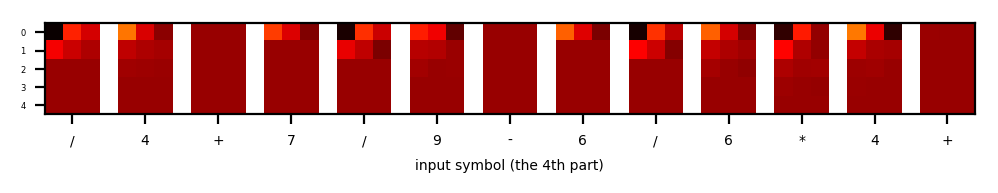

In [30]:
mem_stack(seq, fpath, 'mem')

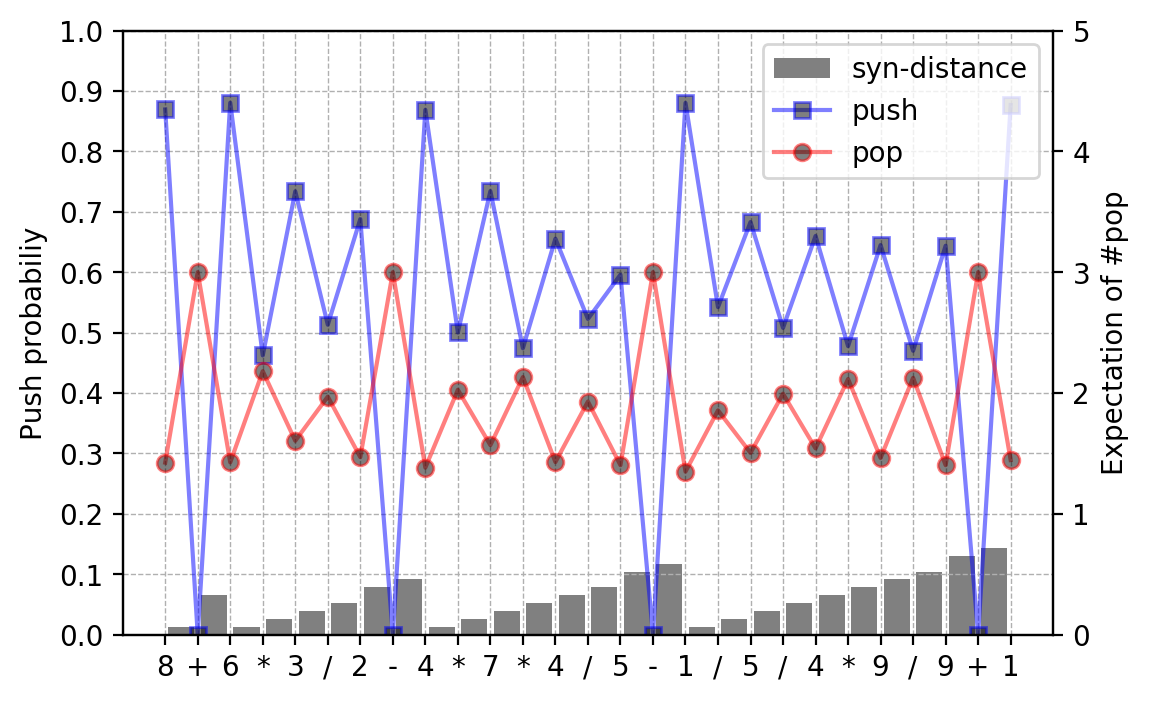

In [136]:
policy_stack(seq, syn_dis, fpath)

['1', '-', '1', '/', '1'] [1, 5, 1, 2] 1
['5', '-', '5', '*', '6'] [1, 5, 1, 2] 5
['8', '-', '6', '*', '5'] [1, 5, 1, 2] 8
['8', '+', '8', '/', '1'] [1, 5, 1, 2] 8
['3', '+', '7', '*', '9'] [1, 5, 1, 2] 6
[[ 1.447  0.751 -1.206  0.21  -1.336 -0.684 -0.061 -1.111 -0.63   1.147]
 [ 0.581  1.049  0.49  -1.441 -0.101 -1.033 -0.581 -0.824 -0.204  1.169]
 [ 1.025 -0.162 -0.191 -0.08  -0.391 -0.86  -0.038 -0.249  0.139  1.84 ]
 [ 1.577  0.077 -0.823  0.16  -1.885 -0.207  0.167 -1.066  0.567  0.548]
 [-0.265 -0.617  0.093  0.47   0.984 -0.495  0.607  0.609  0.178  0.599]]


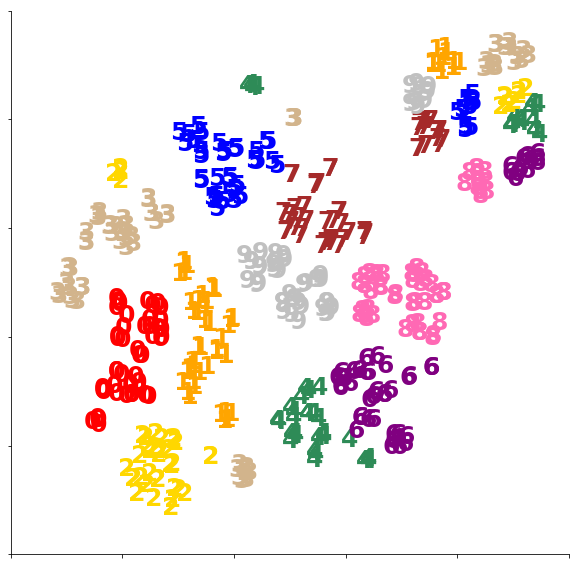

In [112]:
cluster_on(seq, syn_dis, fpath, 'mem', 4, 0, 0+1, 0, 4+1)

['1', '-', '1', '/', '1'] [1, 5, 1, 2] 1
['5', '-', '5', '*', '6'] [1, 5, 1, 2] 5
['8', '-', '6', '*', '5'] [1, 5, 1, 2] 8
['8', '+', '8', '/', '1'] [1, 5, 1, 2] 8
['3', '+', '7', '*', '9'] [1, 5, 1, 2] 6
[[ 1.447  0.751 -1.206  0.21  -1.335 -0.684 -0.061 -1.111 -0.63   1.147]
 [ 0.581  1.049  0.49  -1.441 -0.101 -1.033 -0.581 -0.824 -0.204  1.169]
 [ 1.025 -0.162 -0.191 -0.08  -0.391 -0.86  -0.038 -0.249  0.139  1.84 ]
 [ 1.577  0.077 -0.823  0.16  -1.885 -0.207  0.167 -1.066  0.567  0.548]
 [-0.265 -0.617  0.093  0.47   0.984 -0.495  0.607  0.609  0.178  0.599]]


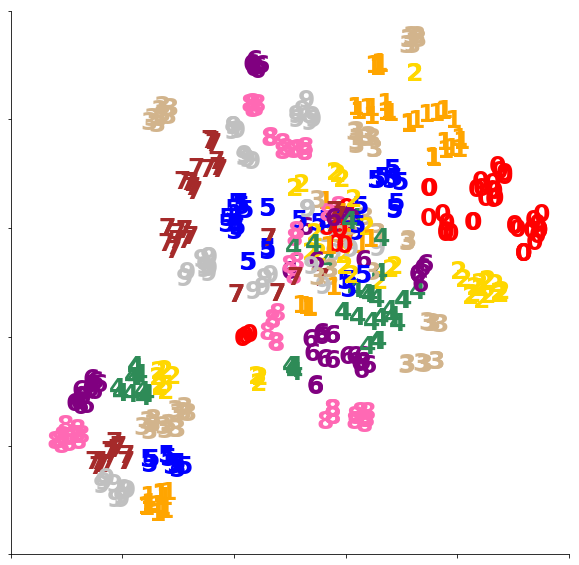

In [46]:
cluster_on(seq, syn_dis, fpath, 'mem_push', 4, 0, 0+1, 0, 4+1)

['1', '-', '1', '/', '1'] [1, 5, 1, 2] 1
['5', '-', '5', '*', '6'] [1, 5, 1, 2] 5
['8', '-', '6', '*', '5'] [1, 5, 1, 2] 8
['8', '+', '8', '/', '1'] [1, 5, 1, 2] 8
['3', '+', '7', '*', '9'] [1, 5, 1, 2] 6
[[ 3.680e-05  1.888e-05 -8.064e-05  3.171e-05 -2.353e-05  4.986e-05
  -2.453e-05 -3.962e-05 -1.788e-05  3.640e-05]
 [ 9.166e-07  9.492e-08 -7.616e-07 -1.049e-07 -9.100e-07 -1.002e-06
  -1.764e-07 -6.973e-07 -2.860e-07 -2.307e-07]
 [ 1.840e-05 -5.302e-06  1.163e-06  6.603e-06 -3.458e-06  6.637e-06
   5.059e-06 -8.304e-06 -1.059e-05 -1.902e-05]
 [-1.442e-07  2.190e-07  4.088e-08 -1.734e-07  2.469e-07 -9.101e-08
  -1.932e-06 -2.826e-07  9.002e-08  9.947e-07]
 [-8.680e-08  5.734e-08  1.232e-09  8.046e-08  2.492e-08 -1.666e-08
   1.642e-08 -6.849e-08  2.458e-09 -1.058e-07]]


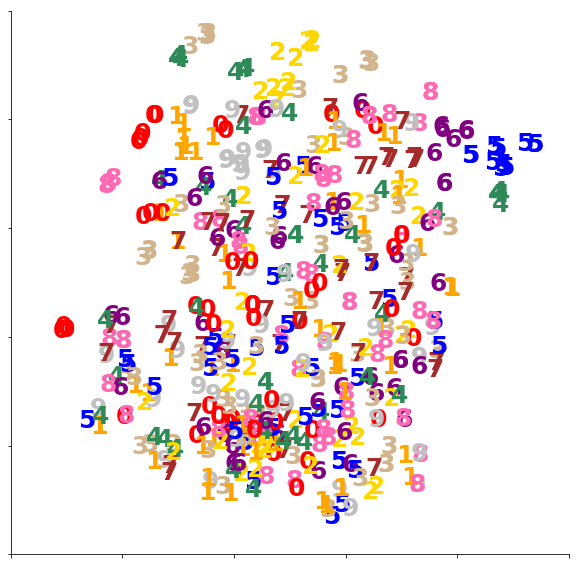

In [48]:
cluster_on(seq, syn_dis, fpath, 'mem_stay', 4, 0, 0+1, 0, 4+1)

['1'] [] 1
['5'] [] 5
['6'] [] 6
['8'] [] 8
['7'] [] 7
[[ 2.177e-01  1.383e+00 -9.362e-01 -1.559e-01  2.361e-01 -2.378e-01
   5.444e-01 -2.093e+00 -1.933e+00  2.754e+00]
 [ 2.171e-04  5.403e-04 -8.565e-05 -2.469e-04 -7.102e-04 -5.192e-04
  -2.584e-04 -3.808e-04 -3.458e-04  1.181e-05]
 [-4.428e-04 -4.574e-04  1.507e-05  7.337e-04 -1.714e-04  5.493e-04
   7.984e-04  5.338e-04 -4.054e-04 -6.872e-04]
 [-2.342e-01  3.459e-01  6.360e-02 -2.722e-01  3.863e-01 -1.466e-01
  -3.102e+00 -4.546e-01  1.385e-01  1.584e+00]
 [-5.930e-04  3.171e-04  1.337e-04  4.818e-04  1.812e-04 -1.369e-04
   1.699e-04 -4.507e-04  3.529e-05 -6.845e-04]]


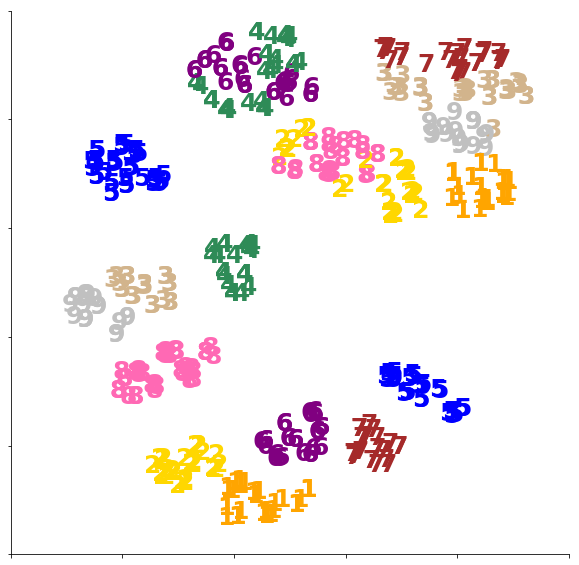

In [49]:
cluster_on(seq, syn_dis, fpath, 'mem_push', 3, 0, 0+1, 2, 2+1)

['/'] [] /
['*'] [] *
['*'] [] *
['/'] [] /
['*'] [] *
[[ 2.177e-01  1.383e+00 -9.362e-01 -1.559e-01  2.361e-01 -2.378e-01
   5.444e-01 -2.093e+00 -1.933e+00  2.754e+00]
 [ 2.171e-04  5.403e-04 -8.565e-05 -2.469e-04 -7.102e-04 -5.192e-04
  -2.584e-04 -3.808e-04 -3.458e-04  1.181e-05]
 [-4.428e-04 -4.574e-04  1.507e-05  7.337e-04 -1.714e-04  5.493e-04
   7.984e-04  5.338e-04 -4.054e-04 -6.872e-04]
 [-2.342e-01  3.459e-01  6.360e-02 -2.722e-01  3.863e-01 -1.466e-01
  -3.102e+00 -4.546e-01  1.385e-01  1.584e+00]
 [-5.930e-04  3.171e-04  1.337e-04  4.818e-04  1.812e-04 -1.369e-04
   1.699e-04 -4.507e-04  3.529e-05 -6.845e-04]]


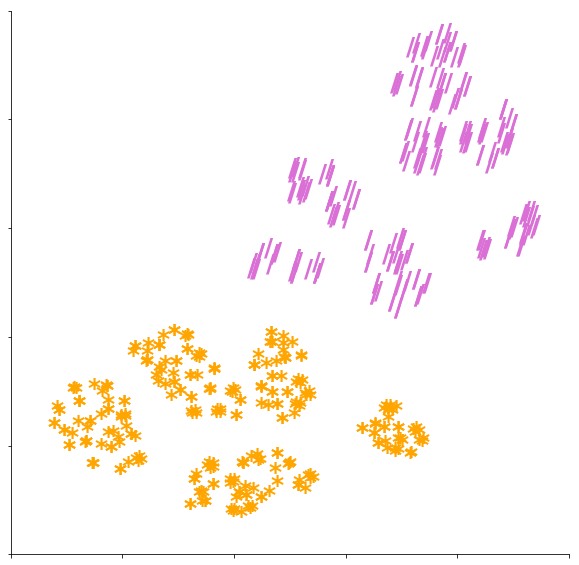

In [50]:
cluster_on(seq, syn_dis, fpath, 'mem_push', 3, 0, 0+1, 3, 3+1)

['1', '/'] [1] 1/
['5', '*'] [1] 5*
['6', '*'] [1] 6*
['8', '/'] [1] 8/
['7', '*'] [1] 7*
[[ 2.177e-01  1.383e+00 -9.362e-01 -1.559e-01  2.361e-01 -2.378e-01
   5.444e-01 -2.093e+00 -1.933e+00  2.754e+00]
 [ 2.195e-04  5.397e-04 -8.789e-05 -2.468e-04 -7.118e-04 -5.214e-04
  -2.585e-04 -3.823e-04 -3.461e-04  1.107e-05]
 [-4.426e-04 -4.575e-04  1.508e-05  7.337e-04 -1.714e-04  5.493e-04
   7.984e-04  5.337e-04 -4.054e-04 -6.874e-04]
 [-2.342e-01  3.459e-01  6.360e-02 -2.722e-01  3.863e-01 -1.466e-01
  -3.102e+00 -4.546e-01  1.385e-01  1.584e+00]
 [-5.930e-04  3.171e-04  1.337e-04  4.818e-04  1.812e-04 -1.369e-04
   1.699e-04 -4.507e-04  3.529e-05 -6.845e-04]]


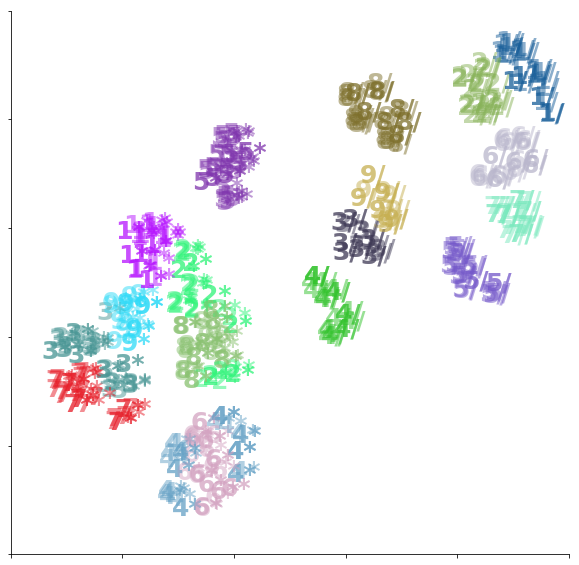

In [119]:
cluster_on(seq, syn_dis, fpath, 'mem', 3, 0, 0+1, 2, 3+1)

['1', '/', '1', '*'] [1, 2, 3] 0*
['5', '*', '6', '/'] [1, 2, 3] 0/
['6', '*', '5', '*'] [1, 2, 3] 0*
['8', '/', '1', '*'] [1, 2, 3] 0*
['7', '*', '9', '*'] [1, 2, 3] 3*
[[ 5.920e-04  3.080e-04 -5.115e-04  9.646e-05 -4.784e-04 -1.279e-04
  -3.501e-04 -2.847e-05 -3.161e-04  2.597e-04]
 [ 1.167e+00  2.826e-01 -3.672e-01 -9.767e-01 -9.602e-01 -2.601e+00
  -4.457e-01 -7.793e-01 -8.159e-01  2.671e+00]
 [ 2.231e-04 -2.010e-04 -4.006e-05  1.456e-04 -8.226e-05  1.077e-04
   1.082e-04 -1.040e-04  1.868e-04  1.130e-04]
 [ 2.466e-04 -1.302e-04 -2.851e-04  7.449e-05 -5.045e-04  5.284e-05
   6.652e-05 -4.844e-05  1.544e-04  1.736e-04]
 [ 3.548e-05  4.494e-04  3.147e-04  9.817e-05  5.191e-04 -6.411e-05
  -6.717e-05 -7.846e-05  2.419e-04 -6.232e-04]]


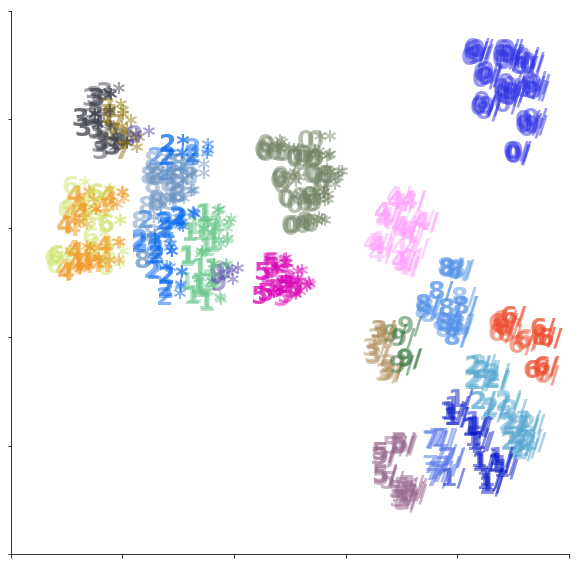

In [137]:
cluster_on(seq, syn_dis, fpath, 'mem', 5, 0, 0+1, 2, 5+1)

<BarContainer object of 5 artists>

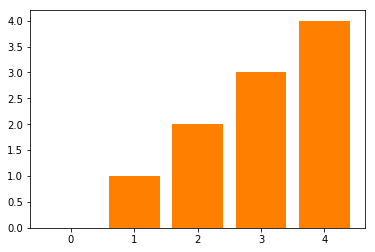

In [94]:
idx = (ord('5')+ord('*'))/200
plt.bar(np.arange(5), np.arange(5), color=plt.cm.Set1(idx))
# plt.cm.Set1()

['1', '-', '1'] [1, 5] 0
['5', '-', '5'] [1, 5] 0
['8', '-', '6'] [1, 5] 2
['8', '+', '8'] [1, 5] 6
['3', '+', '7'] [1, 5] 0
[[ 0.764  0.31  -1.645  0.681 -0.513  1.07  -0.554 -0.703 -0.253  0.592]
 [ 1.558 -0.427 -1.402  0.074 -0.985 -1.384 -0.054 -0.94  -0.17  -0.468]
 [ 1.365 -0.383  0.086  0.475 -0.252  0.48   0.36  -0.622 -0.774 -1.392]
 [ 0.365  0.732  0.26  -0.784  1.297  0.068  0.013  0.119  0.776  1.641]
 [ 0.699  0.386 -1.431  0.122 -0.324  0.396 -0.787  0.356 -0.23   0.419]]


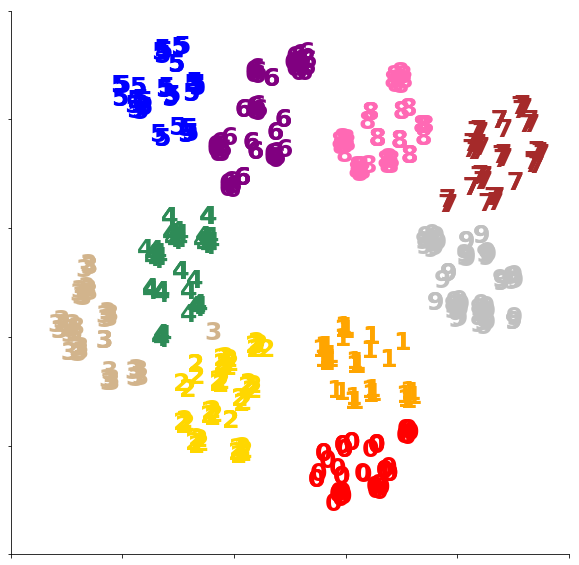

In [51]:
cluster_on(seq, syn_dis, fpath, 'mem_push', 2, 0, 0+1, 0, 2+1)

['1', '-', '1', '/', '1', '*', '9'] [1, 5, 1, 2, 3, 4] 1
['5', '-', '5', '*', '6', '/', '6'] [1, 5, 1, 2, 3, 4] 5
['8', '-', '6', '*', '5', '*', '6'] [1, 5, 1, 2, 3, 4] 8
['8', '+', '8', '/', '1', '*', '8'] [1, 5, 1, 2, 3, 4] 8
['3', '+', '7', '*', '9', '*', '9'] [1, 5, 1, 2, 3, 4] 0
[[ 7.884e-01  5.171e-01 -4.377e-01  7.691e-01 -7.512e-01  3.126e-01
  -1.902e-01 -4.170e-01 -7.580e-01  2.913e-01]
 [ 7.400e-01  9.010e-01  3.391e-01 -1.310e+00 -3.762e-01 -1.400e+00
  -4.669e-01 -9.155e-01 -2.396e-01  1.334e+00]
 [ 6.892e-01 -4.160e-01 -2.706e-01  3.858e-01 -1.033e+00 -3.615e-01
   7.867e-02 -1.405e-01  3.710e-02  1.745e+00]
 [ 8.214e-01 -4.599e-01  2.895e-01  9.548e-04 -5.534e-01 -3.707e-01
   2.212e-01  1.388e-01  4.509e-01  1.367e+00]
 [-2.686e-01 -4.240e-01 -1.215e+00  1.334e+00 -4.388e-01  6.526e-01
  -4.025e-01  1.552e+00 -8.063e-01  2.043e-01]]


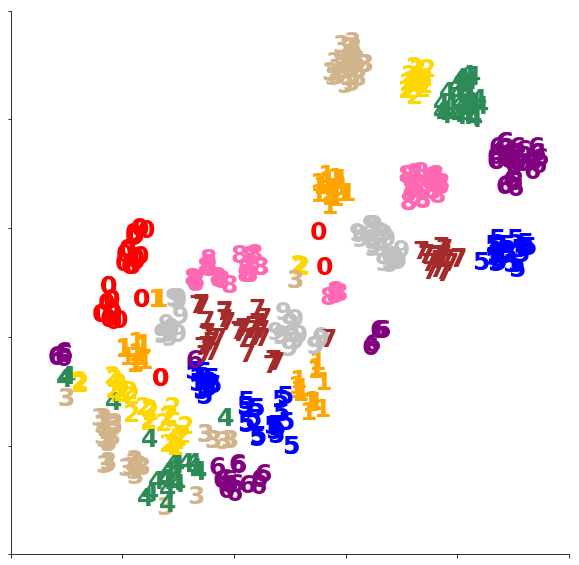

In [140]:
cluster_on(seq, syn_dis, fpath, 'mem', 6, 0, 0+1, 0, 6+1)

['1', '-', '1', '/', '1', '*', '9'] [1, 5, 1, 2, 3, 4] 1
['5', '-', '5', '*', '6', '/', '6'] [1, 5, 1, 2, 3, 4] 5
['8', '-', '6', '*', '5', '*', '6'] [1, 5, 1, 2, 3, 4] 8
['8', '+', '8', '/', '1', '*', '8'] [1, 5, 1, 2, 3, 4] 8
['3', '+', '7', '*', '9', '*', '9'] [1, 5, 1, 2, 3, 4] 0
[[ 7.884e-01  5.171e-01 -4.377e-01  7.691e-01 -7.512e-01  3.126e-01
  -1.902e-01 -4.170e-01 -7.580e-01  2.913e-01]
 [ 1.135e-01  1.072e-01  6.082e-02 -1.107e-01 -1.272e-01 -1.894e-01
   2.617e-02 -1.894e-01  5.509e-02  1.496e-02]
 [ 6.892e-01 -4.160e-01 -2.706e-01  3.858e-01 -1.033e+00 -3.615e-01
   7.867e-02 -1.405e-01  3.710e-02  1.745e+00]
 [ 8.214e-01 -4.599e-01  2.895e-01  9.548e-04 -5.534e-01 -3.707e-01
   2.212e-01  1.388e-01  4.509e-01  1.367e+00]
 [-2.686e-01 -4.240e-01 -1.215e+00  1.334e+00 -4.388e-01  6.526e-01
  -4.025e-01  1.552e+00 -8.063e-01  2.043e-01]]


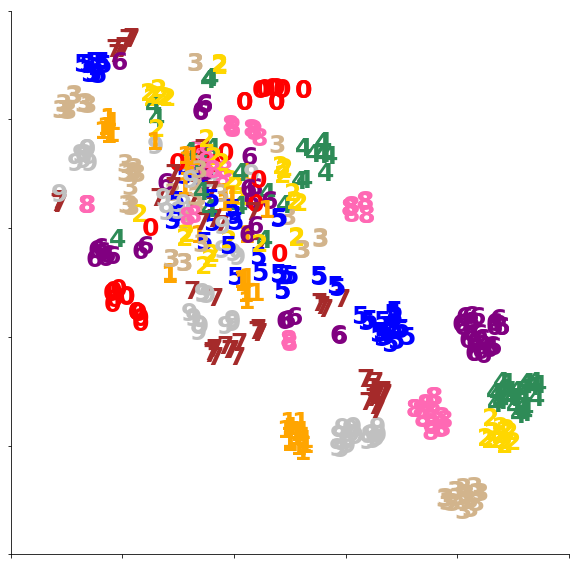

In [52]:
cluster_on(seq, syn_dis, fpath, 'mem_push', 6, 0, 0+1, 0, 6+1)

['1', '-', '1', '/', '1', '*', '9'] [1, 5, 1, 2, 3, 4] 1
['5', '-', '5', '*', '6', '/', '6'] [1, 5, 1, 2, 3, 4] 5
['8', '-', '6', '*', '5', '*', '6'] [1, 5, 1, 2, 3, 4] 8
['8', '+', '8', '/', '1', '*', '8'] [1, 5, 1, 2, 3, 4] 8
['3', '+', '7', '*', '9', '*', '9'] [1, 5, 1, 2, 3, 4] 0
[[ 1.087e-07  5.665e-08 -9.382e-08  1.759e-08 -8.913e-08 -2.628e-08
  -5.777e-08 -1.402e-08 -5.703e-08  5.216e-08]
 [ 6.266e-01  7.939e-01  2.782e-01 -1.199e+00 -2.489e-01 -1.211e+00
  -4.930e-01 -7.261e-01 -2.947e-01  1.319e+00]
 [ 1.292e-07 -1.161e-07 -2.319e-08  8.404e-08 -4.763e-08  6.192e-08
   6.250e-08 -6.016e-08  1.079e-07  6.578e-08]
 [ 6.196e-08 -3.194e-08 -7.080e-08  1.845e-08 -1.256e-07  1.282e-08
   1.650e-08 -1.280e-08  3.844e-08  4.314e-08]
 [ 5.781e-09  7.331e-08  5.133e-08  1.602e-08  8.467e-08 -1.046e-08
  -1.095e-08 -1.280e-08  3.945e-08 -1.017e-07]]


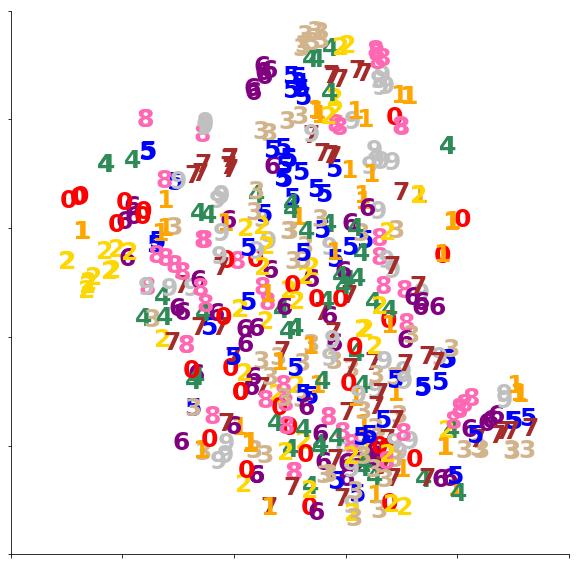

In [53]:
cluster_on(seq, syn_dis, fpath, 'mem_stay', 6, 0, 0+1, 0, 6+1)

['1', '-', '1', '/', '1', '*', '9'] [1, 5, 1, 2, 3, 4] 1
['5', '-', '5', '*', '6', '/', '6'] [1, 5, 1, 2, 3, 4] 5
['8', '-', '6', '*', '5', '*', '6'] [1, 5, 1, 2, 3, 4] 8
['8', '+', '8', '/', '1', '*', '8'] [1, 5, 1, 2, 3, 4] 8
['3', '+', '7', '*', '9', '*', '9'] [1, 5, 1, 2, 3, 4] 0
[[ 7.884e-01  5.171e-01 -4.377e-01  7.691e-01 -7.512e-01  3.126e-01
  -1.902e-01 -4.170e-01 -7.580e-01  2.913e-01]
 [ 7.400e-01  9.010e-01  3.391e-01 -1.310e+00 -3.762e-01 -1.400e+00
  -4.669e-01 -9.155e-01 -2.396e-01  1.334e+00]
 [ 6.892e-01 -4.160e-01 -2.706e-01  3.858e-01 -1.033e+00 -3.615e-01
   7.867e-02 -1.405e-01  3.710e-02  1.745e+00]
 [ 8.214e-01 -4.599e-01  2.895e-01  9.548e-04 -5.534e-01 -3.707e-01
   2.212e-01  1.388e-01  4.509e-01  1.367e+00]
 [-2.686e-01 -4.240e-01 -1.215e+00  1.334e+00 -4.388e-01  6.526e-01
  -4.025e-01  1.552e+00 -8.063e-01  2.043e-01]]


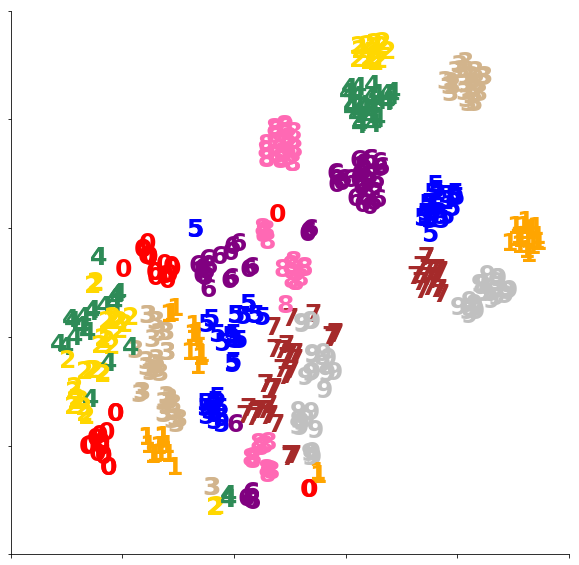

In [54]:
cluster_on(seq, syn_dis, fpath, 'mem', 6, 0, 0+1, 0, 6+1)

['1'] [] 1
['5'] [] 5
['6'] [] 6
['8'] [] 8
['7'] [] 7
[[ 2.177e-01  1.383e+00 -9.362e-01 -1.559e-01  2.361e-01 -2.378e-01
   5.444e-01 -2.093e+00 -1.933e+00  2.754e+00]
 [ 2.195e-04  5.397e-04 -8.789e-05 -2.468e-04 -7.118e-04 -5.214e-04
  -2.585e-04 -3.823e-04 -3.461e-04  1.107e-05]
 [-4.426e-04 -4.575e-04  1.508e-05  7.337e-04 -1.714e-04  5.493e-04
   7.984e-04  5.337e-04 -4.054e-04 -6.874e-04]
 [-2.342e-01  3.459e-01  6.360e-02 -2.722e-01  3.863e-01 -1.466e-01
  -3.102e+00 -4.546e-01  1.385e-01  1.584e+00]
 [-5.930e-04  3.171e-04  1.337e-04  4.818e-04  1.812e-04 -1.369e-04
   1.699e-04 -4.507e-04  3.529e-05 -6.845e-04]]


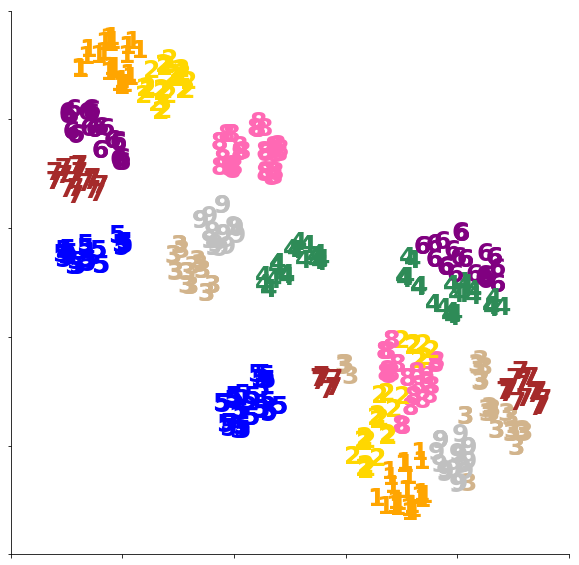

In [44]:
cluster_on(seq, syn_dis, fpath, 'mem', 3, 0, 0+1, 2, 2+1)

['/'] [] /
['*'] [] *
['*'] [] *
['/'] [] /
['*'] [] *
[[ 2.177e-01  1.383e+00 -9.362e-01 -1.559e-01  2.361e-01 -2.378e-01
   5.444e-01 -2.093e+00 -1.933e+00  2.754e+00]
 [ 2.195e-04  5.397e-04 -8.789e-05 -2.468e-04 -7.118e-04 -5.214e-04
  -2.585e-04 -3.823e-04 -3.461e-04  1.107e-05]
 [-4.426e-04 -4.575e-04  1.508e-05  7.337e-04 -1.714e-04  5.493e-04
   7.984e-04  5.337e-04 -4.054e-04 -6.874e-04]
 [-2.342e-01  3.459e-01  6.360e-02 -2.722e-01  3.863e-01 -1.466e-01
  -3.102e+00 -4.546e-01  1.385e-01  1.584e+00]
 [-5.930e-04  3.171e-04  1.337e-04  4.818e-04  1.812e-04 -1.369e-04
   1.699e-04 -4.507e-04  3.529e-05 -6.845e-04]]


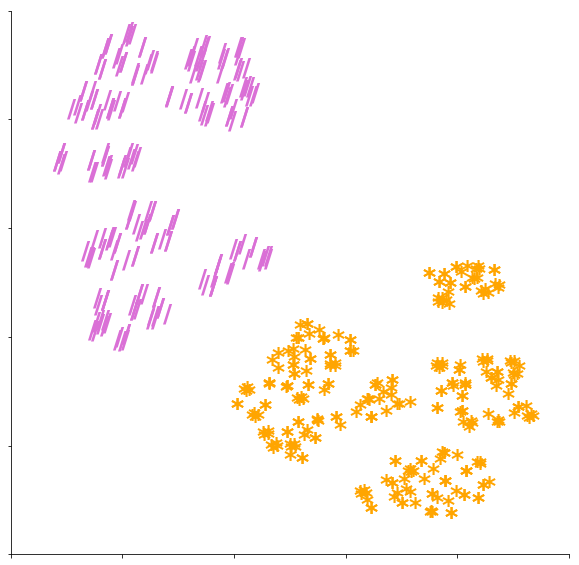

In [45]:
cluster_on(seq, syn_dis, fpath, 'mem', 3, 0, 0+1, 3, 3+1)

# push

In [58]:
import torch
from torch import nn
from torch.nn import functional as F

In [57]:
N=5
update_kernel = nn.Parameter(torch.eye(N + 1).
            view(N + 1, 1, N + 1, 1),
            requires_grad=False)

In [60]:
mem = torch.rand(1, 5, 5)
mem_padded = F.pad(mem.unsqueeze(1),
                           (0, 0, 0, N),
                           'constant', 0)

In [62]:
mem_padded.shape

torch.Size([1, 1, 10, 5])

In [66]:
mem

tensor([[[ 0.1243,  0.7317,  0.6759,  0.6089,  0.1838],
         [ 0.5982,  0.2799,  0.7794,  0.0065,  0.5942],
         [ 0.1151,  0.5710,  0.8366,  0.2908,  0.3432],
         [ 0.6152,  0.9865,  0.7862,  0.1855,  0.6251],
         [ 0.5548,  0.1494,  0.4633,  0.0554,  0.7050]]])

In [63]:
mem_padded

tensor([[[[ 0.1243,  0.7317,  0.6759,  0.6089,  0.1838],
          [ 0.5982,  0.2799,  0.7794,  0.0065,  0.5942],
          [ 0.1151,  0.5710,  0.8366,  0.2908,  0.3432],
          [ 0.6152,  0.9865,  0.7862,  0.1855,  0.6251],
          [ 0.5548,  0.1494,  0.4633,  0.0554,  0.7050],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]]])

In [64]:
m_stay = F.conv2d(mem_padded, update_kernel)

In [65]:
m_stay

tensor([[[[ 0.1243,  0.7317,  0.6759,  0.6089,  0.1838],
          [ 0.5982,  0.2799,  0.7794,  0.0065,  0.5942],
          [ 0.1151,  0.5710,  0.8366,  0.2908,  0.3432],
          [ 0.6152,  0.9865,  0.7862,  0.1855,  0.6251],
          [ 0.5548,  0.1494,  0.4633,  0.0554,  0.7050]],

         [[ 0.5982,  0.2799,  0.7794,  0.0065,  0.5942],
          [ 0.1151,  0.5710,  0.8366,  0.2908,  0.3432],
          [ 0.6152,  0.9865,  0.7862,  0.1855,  0.6251],
          [ 0.5548,  0.1494,  0.4633,  0.0554,  0.7050],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

         [[ 0.1151,  0.5710,  0.8366,  0.2908,  0.3432],
          [ 0.6152,  0.9865,  0.7862,  0.1855,  0.6251],
          [ 0.5548,  0.1494,  0.4633,  0.0554,  0.7050],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

         [[ 0.6152,  0.9865,  0.7862,  0.1855,  0.6251],
          [ 0.5548,  0.1494,  0.4633,  0.0554,  0.7050],
          [ 0.0000,  0.00

In [67]:
m_stay[:,:,:-1]

tensor([[[[ 0.1243,  0.7317,  0.6759,  0.6089,  0.1838],
          [ 0.5982,  0.2799,  0.7794,  0.0065,  0.5942],
          [ 0.1151,  0.5710,  0.8366,  0.2908,  0.3432],
          [ 0.6152,  0.9865,  0.7862,  0.1855,  0.6251]],

         [[ 0.5982,  0.2799,  0.7794,  0.0065,  0.5942],
          [ 0.1151,  0.5710,  0.8366,  0.2908,  0.3432],
          [ 0.6152,  0.9865,  0.7862,  0.1855,  0.6251],
          [ 0.5548,  0.1494,  0.4633,  0.0554,  0.7050]],

         [[ 0.1151,  0.5710,  0.8366,  0.2908,  0.3432],
          [ 0.6152,  0.9865,  0.7862,  0.1855,  0.6251],
          [ 0.5548,  0.1494,  0.4633,  0.0554,  0.7050],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

         [[ 0.6152,  0.9865,  0.7862,  0.1855,  0.6251],
          [ 0.5548,  0.1494,  0.4633,  0.0554,  0.7050],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

         [[ 0.5548,  0.1494,  0.4633,  0.0554,  0.7050],
          [ 0.0000,  0.

correct prediction%: 0.992


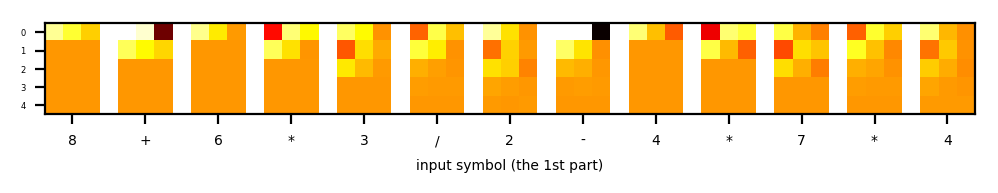

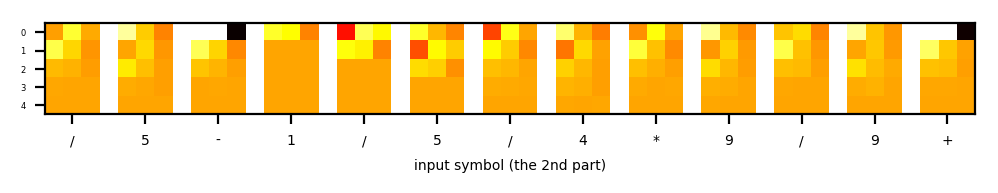

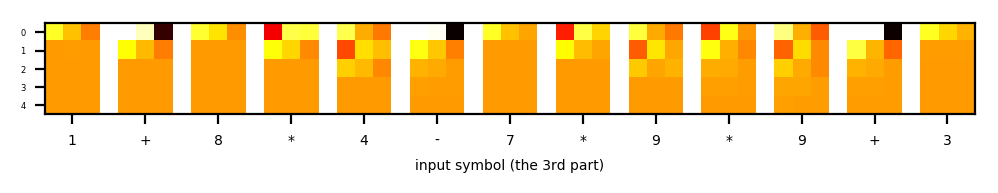

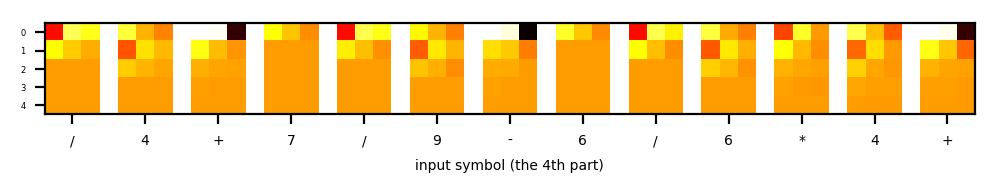

In [70]:
fpath = 'feval-analy_d23_ne10-sarnn-1544172104.txt'
mem_stack(seq, fpath, 'mem_push_0')

['/'] [] /
['*'] [] *
['*'] [] *
['/'] [] /
['*'] [] *
[[ 0.218  1.383 -0.936 -0.156  0.236 -0.238  0.544 -2.093 -1.933  2.754]
 [ 0.946  2.355 -0.373 -1.076 -3.095 -2.263 -1.126 -1.66  -1.507  0.051]
 [-1.388 -1.434  0.047  2.3   -0.537  1.722  2.503  1.674 -1.271 -2.155]
 [-0.234  0.346  0.064 -0.272  0.386 -0.147 -3.102 -0.455  0.138  1.584]
 [-2.61   1.395  0.588  2.12   0.797 -0.603  0.748 -1.983  0.155 -3.012]]


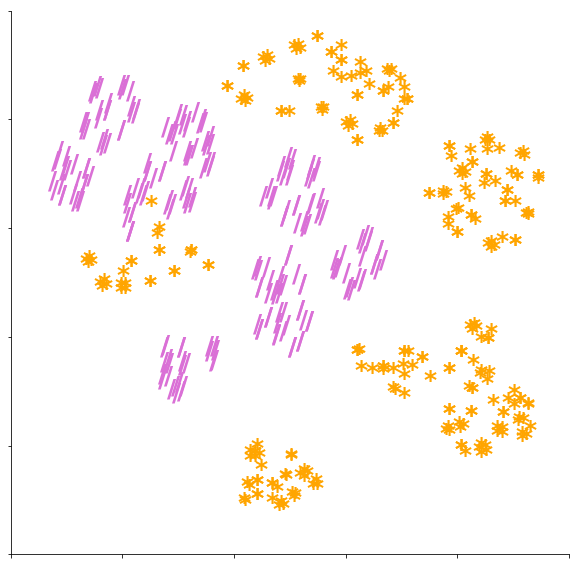

In [73]:
cluster_on(seq, syn_dis, fpath, 'mem_push_0', 3, 0, 0+1, 3, 3+1)

['1', '-', '1'] [1, 5] 0
['5', '-', '5'] [1, 5] 0
['8', '-', '6'] [1, 5] 2
['8', '+', '8'] [1, 5] 6
['3', '+', '7'] [1, 5] 0
[[ 0.764  0.31  -1.645  0.681 -0.513  1.07  -0.554 -0.703 -0.253  0.592]
 [ 1.558 -0.427 -1.402  0.074 -0.985 -1.384 -0.054 -0.94  -0.17  -0.468]
 [ 1.365 -0.383  0.086  0.475 -0.252  0.48   0.36  -0.622 -0.774 -1.392]
 [ 0.365  0.732  0.26  -0.784  1.297  0.068  0.013  0.119  0.776  1.641]
 [ 0.699  0.386 -1.431  0.122 -0.324  0.396 -0.787  0.356 -0.23   0.419]]


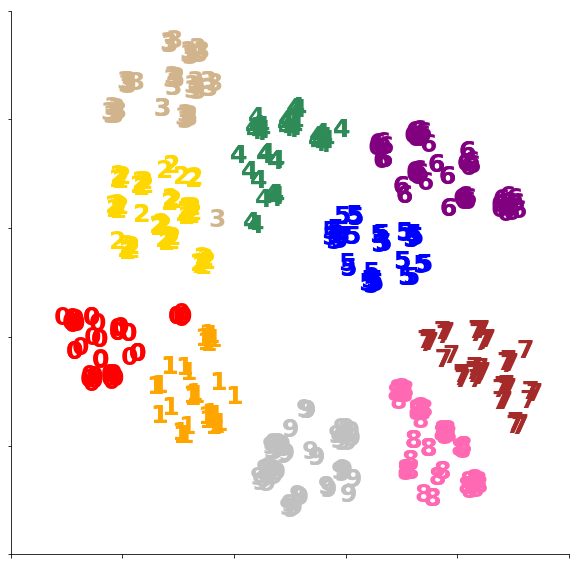

In [74]:
cluster_on(seq, syn_dis, fpath, 'mem_push_0', 3, 1, 1+1, 0, 2+1)

['1'] [] 1
['5'] [] 5
['6'] [] 6
['8'] [] 8
['7'] [] 7
[[ 7.644e-01  3.099e-01 -1.645e+00  6.810e-01 -5.130e-01  1.070e+00
  -5.541e-01 -7.028e-01 -2.531e-01  5.920e-01]
 [ 3.569e-06 -9.778e-07 -3.212e-06  1.692e-07 -2.256e-06 -3.170e-06
  -1.230e-07 -2.154e-06 -3.898e-07 -1.071e-06]
 [ 1.254e-04 -3.520e-05  7.860e-06  4.357e-05 -2.316e-05  4.410e-05
   3.301e-05 -5.712e-05 -7.108e-05 -1.278e-04]
 [ 3.655e-01  7.323e-01  2.596e-01 -7.838e-01  1.297e+00  6.822e-02
   1.328e-02  1.191e-01  7.763e-01  1.641e+00]
 [ 4.610e-08  2.547e-08 -9.443e-08  8.065e-09 -2.139e-08  2.614e-08
  -5.190e-08  2.346e-08 -1.516e-08  2.765e-08]]


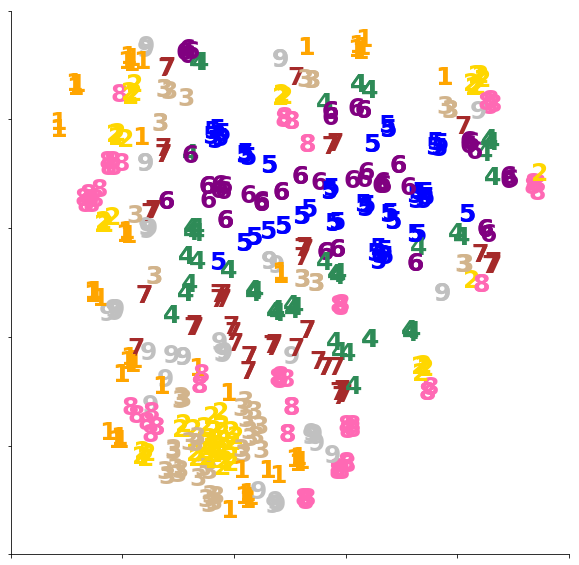

In [77]:
cluster_on(seq, syn_dis, fpath, 'mem', 3, 1, 1+1, 2, 2+1)

['1'] [] 1
['5'] [] 5
['6'] [] 6
['8'] [] 8
['7'] [] 7
[[ 2.177e-01  1.383e+00 -9.362e-01 -1.559e-01  2.361e-01 -2.378e-01
   5.444e-01 -2.093e+00 -1.933e+00  2.754e+00]
 [ 2.195e-04  5.397e-04 -8.789e-05 -2.468e-04 -7.118e-04 -5.214e-04
  -2.585e-04 -3.823e-04 -3.461e-04  1.107e-05]
 [-4.426e-04 -4.575e-04  1.508e-05  7.337e-04 -1.714e-04  5.493e-04
   7.984e-04  5.337e-04 -4.054e-04 -6.874e-04]
 [-2.342e-01  3.459e-01  6.360e-02 -2.722e-01  3.863e-01 -1.466e-01
  -3.102e+00 -4.546e-01  1.385e-01  1.584e+00]
 [-5.930e-04  3.171e-04  1.337e-04  4.818e-04  1.812e-04 -1.369e-04
   1.699e-04 -4.507e-04  3.529e-05 -6.845e-04]]


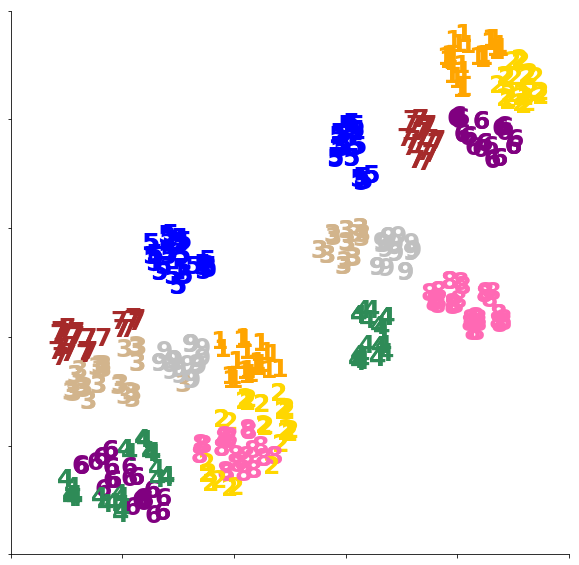

In [78]:
cluster_on(seq, syn_dis, fpath, 'mem', 3, 0, 0+1, 2, 2+1)

['/'] [] /
['*'] [] *
['*'] [] *
['/'] [] /
['*'] [] *
[[ 7.644e-01  3.099e-01 -1.645e+00  6.810e-01 -5.130e-01  1.070e+00
  -5.541e-01 -7.028e-01 -2.531e-01  5.920e-01]
 [ 3.569e-06 -9.778e-07 -3.212e-06  1.692e-07 -2.256e-06 -3.170e-06
  -1.230e-07 -2.154e-06 -3.898e-07 -1.071e-06]
 [ 1.254e-04 -3.520e-05  7.860e-06  4.357e-05 -2.316e-05  4.410e-05
   3.301e-05 -5.712e-05 -7.108e-05 -1.278e-04]
 [ 3.655e-01  7.323e-01  2.596e-01 -7.838e-01  1.297e+00  6.822e-02
   1.328e-02  1.191e-01  7.763e-01  1.641e+00]
 [ 4.610e-08  2.547e-08 -9.443e-08  8.065e-09 -2.139e-08  2.614e-08
  -5.190e-08  2.346e-08 -1.516e-08  2.765e-08]]


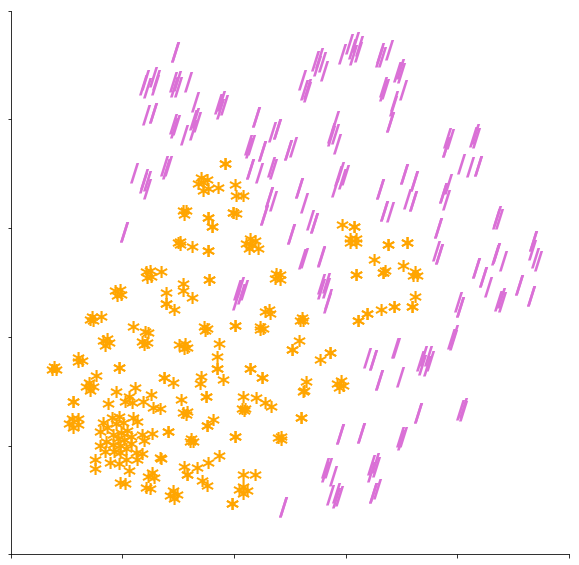

In [79]:
cluster_on(seq, syn_dis, fpath, 'mem', 3, 1, 1+1, 3, 3+1)

['/'] [] /
['*'] [] *
['*'] [] *
['/'] [] /
['*'] [] *
[[ 2.177e-01  1.383e+00 -9.362e-01 -1.559e-01  2.361e-01 -2.378e-01
   5.444e-01 -2.093e+00 -1.933e+00  2.754e+00]
 [ 2.195e-04  5.397e-04 -8.789e-05 -2.468e-04 -7.118e-04 -5.214e-04
  -2.585e-04 -3.823e-04 -3.461e-04  1.107e-05]
 [-4.426e-04 -4.575e-04  1.508e-05  7.337e-04 -1.714e-04  5.493e-04
   7.984e-04  5.337e-04 -4.054e-04 -6.874e-04]
 [-2.342e-01  3.459e-01  6.360e-02 -2.722e-01  3.863e-01 -1.466e-01
  -3.102e+00 -4.546e-01  1.385e-01  1.584e+00]
 [-5.930e-04  3.171e-04  1.337e-04  4.818e-04  1.812e-04 -1.369e-04
   1.699e-04 -4.507e-04  3.529e-05 -6.845e-04]]


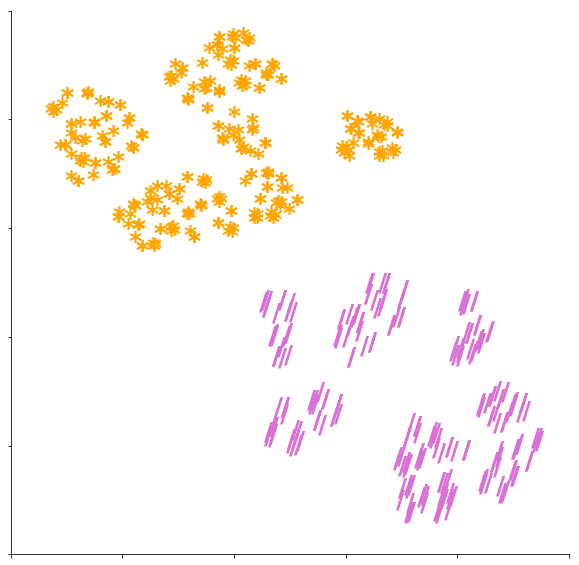

In [80]:
cluster_on(seq, syn_dis, fpath, 'mem', 3, 0, 0+1, 3, 3+1)

['1'] [] 1
['5'] [] 5
['6'] [] 6
['8'] [] 8
['7'] [] 7
[[ 7.644e-01  3.099e-01 -1.645e+00  6.810e-01 -5.130e-01  1.070e+00
  -5.541e-01 -7.028e-01 -2.531e-01  5.920e-01]
 [ 3.569e-06 -9.778e-07 -3.212e-06  1.692e-07 -2.256e-06 -3.170e-06
  -1.230e-07 -2.154e-06 -3.898e-07 -1.071e-06]
 [ 1.254e-04 -3.520e-05  7.860e-06  4.357e-05 -2.316e-05  4.410e-05
   3.301e-05 -5.712e-05 -7.108e-05 -1.278e-04]
 [ 3.655e-01  7.323e-01  2.596e-01 -7.838e-01  1.297e+00  6.822e-02
   1.328e-02  1.191e-01  7.763e-01  1.641e+00]
 [ 4.610e-08  2.547e-08 -9.443e-08  8.065e-09 -2.139e-08  2.614e-08
  -5.190e-08  2.346e-08 -1.516e-08  2.765e-08]]


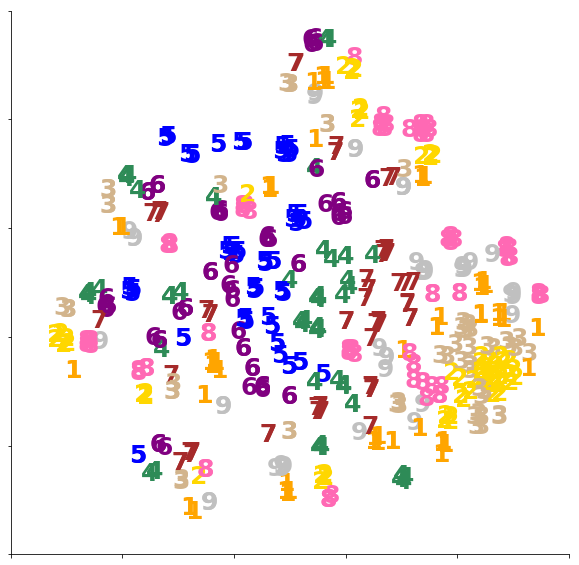

In [83]:
cluster_on(seq, syn_dis, fpath, 'mem', 3, 1, 1+1, 2, 2+1)

['/'] [] /
['*'] [] *
['*'] [] *
['/'] [] /
['*'] [] *
[[ 1.447  0.751 -1.206  0.21  -1.336 -0.684 -0.061 -1.111 -0.63   1.147]
 [ 0.581  1.049  0.49  -1.441 -0.101 -1.033 -0.581 -0.824 -0.204  1.169]
 [ 1.025 -0.162 -0.191 -0.08  -0.391 -0.86  -0.038 -0.249  0.139  1.84 ]
 [ 1.577  0.077 -0.823  0.16  -1.885 -0.207  0.167 -1.066  0.567  0.548]
 [-0.265 -0.617  0.093  0.47   0.984 -0.495  0.607  0.609  0.178  0.599]]


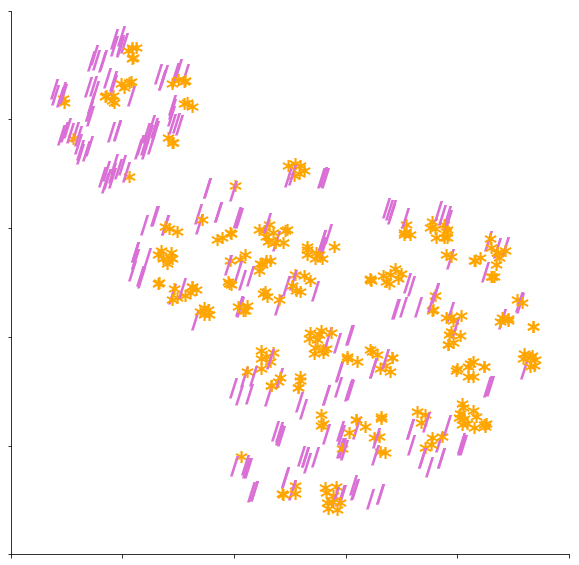

In [81]:
cluster_on(seq, syn_dis, fpath, 'mem', 4, 0, 0+1, 3, 3+1)

correct prediction%: 0.992


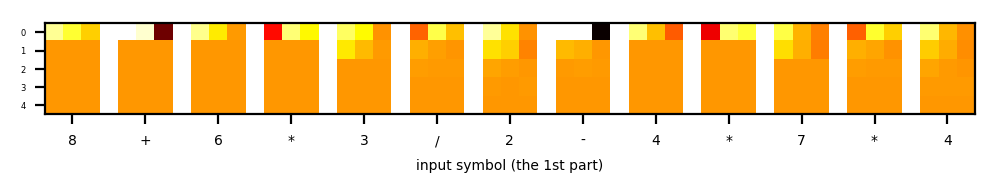

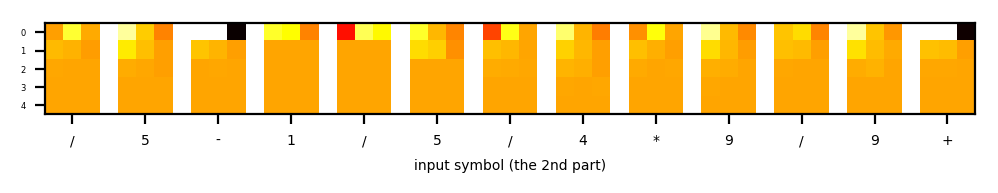

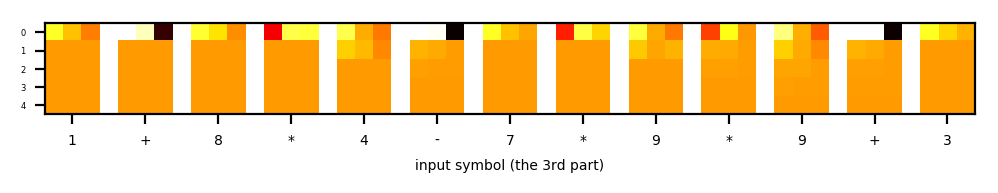

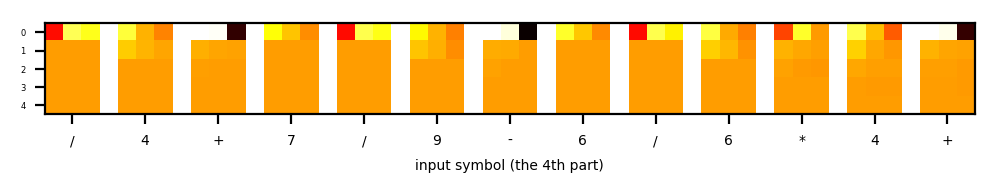

In [71]:
mem_stack(seq, fpath, 'mem_push_1')

correct prediction%: 0.992


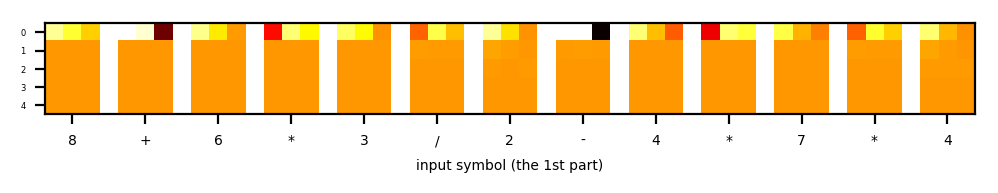

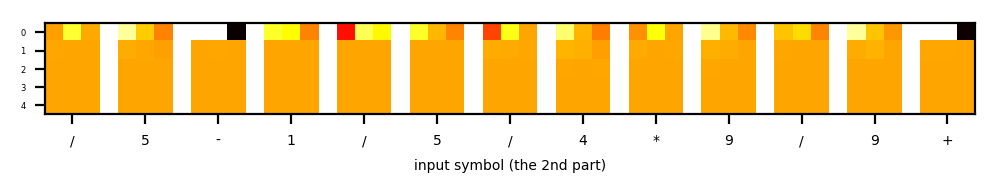

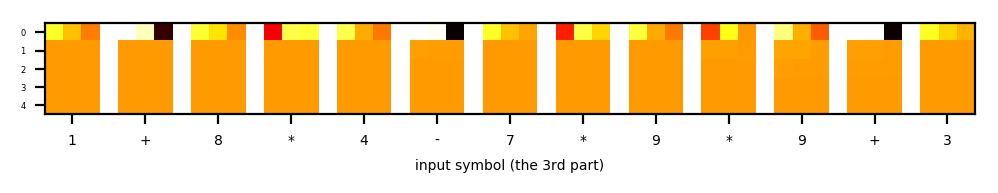

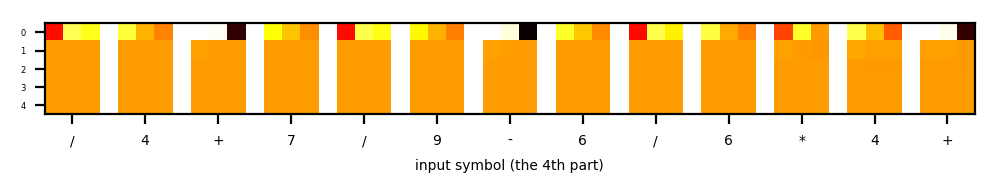

In [84]:
mem_stack(seq, fpath, 'mem_push_2')

['/'] [] /
['*'] [] *
['*'] [] *
['/'] [] /
['*'] [] *
[[ 0.218  1.383 -0.936 -0.156  0.236 -0.238  0.544 -2.093 -1.933  2.754]
 [ 0.946  2.355 -0.373 -1.076 -3.095 -2.263 -1.126 -1.66  -1.507  0.051]
 [-1.388 -1.434  0.047  2.3   -0.537  1.722  2.503  1.674 -1.271 -2.155]
 [-0.234  0.346  0.064 -0.272  0.386 -0.147 -3.102 -0.455  0.138  1.584]
 [-2.61   1.395  0.588  2.12   0.797 -0.603  0.748 -1.983  0.155 -3.012]]


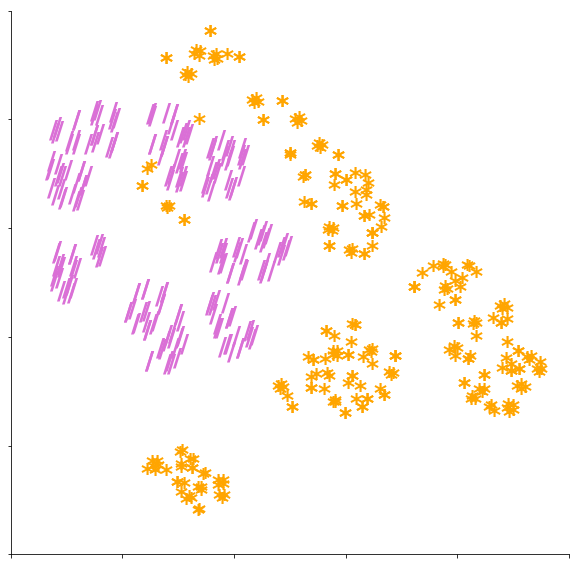

In [76]:
cluster_on(seq, syn_dis, fpath, 'mem_push_1', 3, 0, 0+1, 3, 3+1)

correct prediction%: 0.992


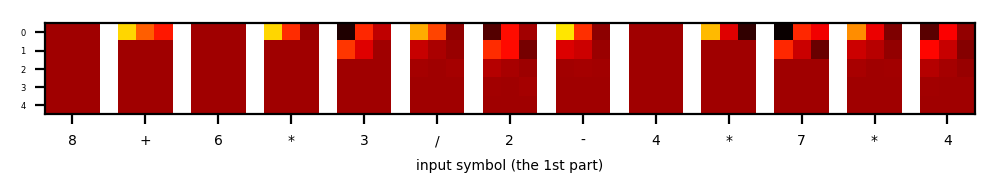

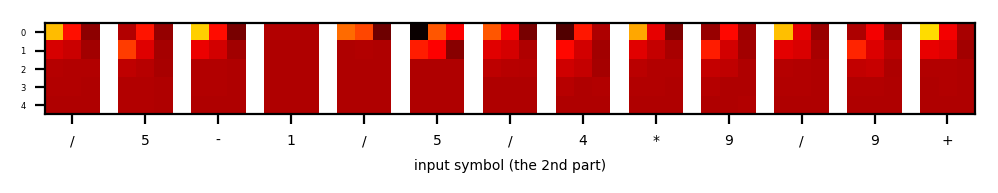

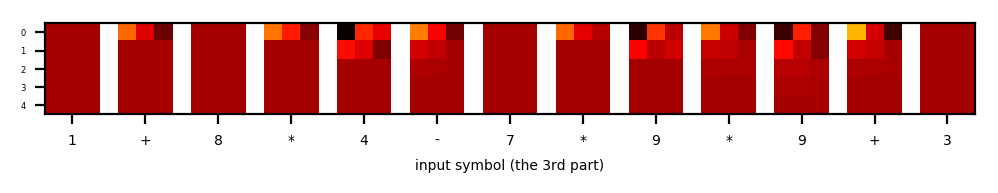

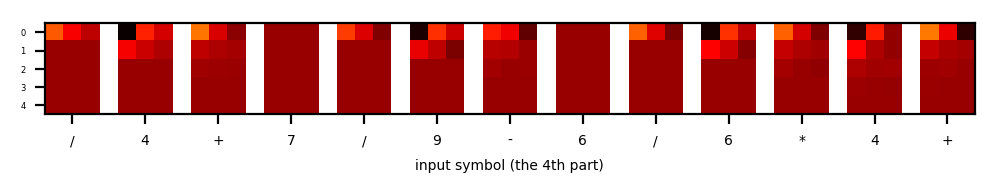

In [85]:
mem_stack(seq, fpath, 'mem_stay_0')

correct prediction%: 0.992


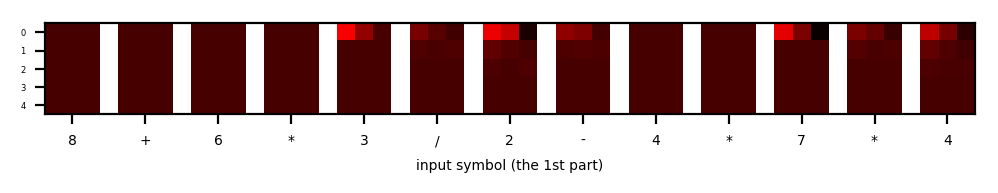

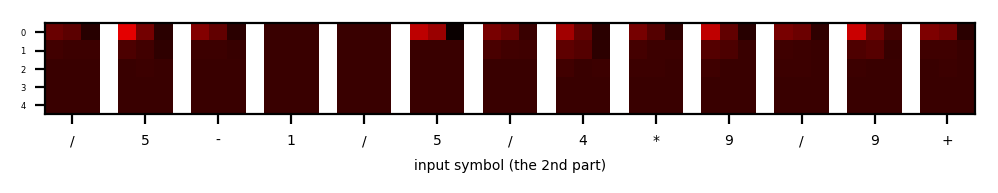

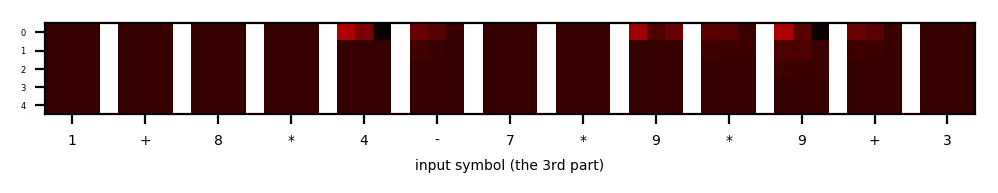

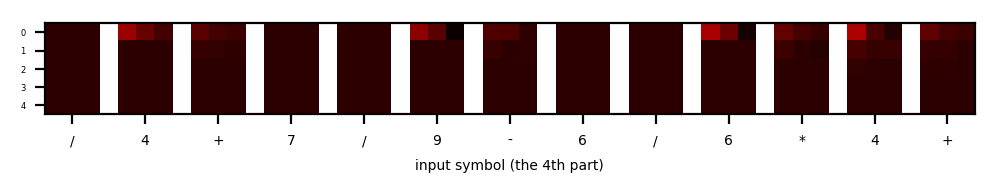

In [72]:
mem_stack(seq, fpath, 'mem_stay_1')

correct prediction%: 0.992


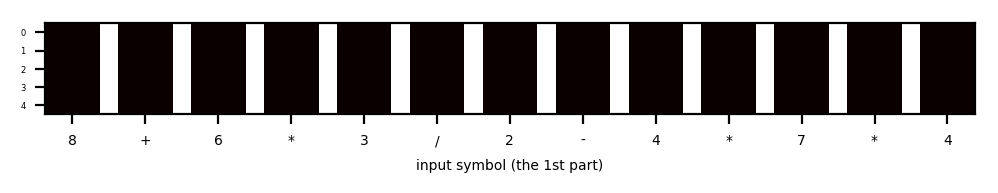

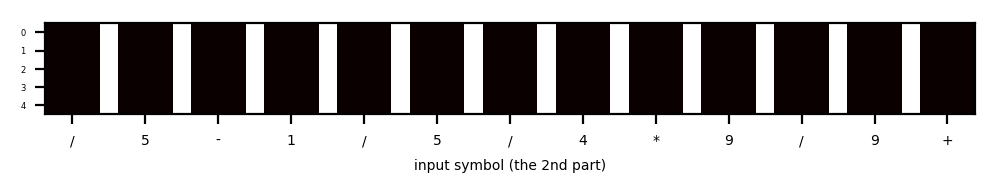

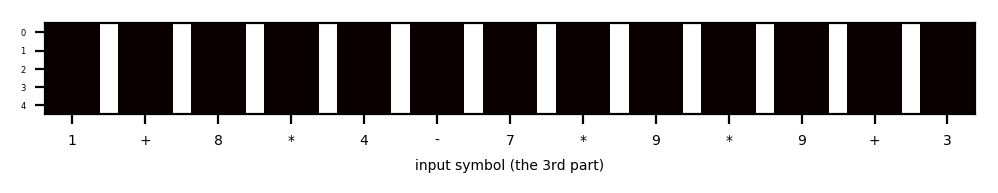

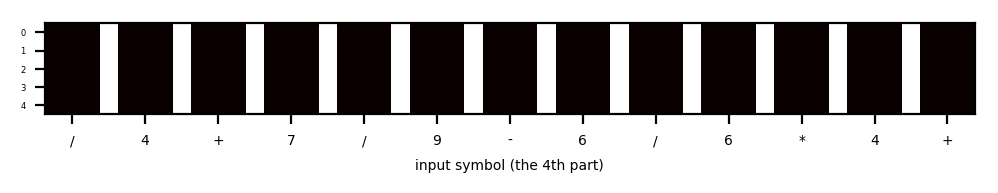

In [75]:
mem_stack(seq, fpath, 'mem_stay_4')

['1', '-', '1'] [1, 5] 0
['5', '-', '5'] [1, 5] 0
['8', '-', '6'] [1, 5] 2
['8', '+', '8'] [1, 5] 6
['3', '+', '7'] [1, 5] 0
[[ 7.644e-01  3.099e-01 -1.645e+00  6.810e-01 -5.130e-01  1.070e+00
  -5.541e-01 -7.028e-01 -2.531e-01  5.920e-01]
 [ 3.569e-06 -9.778e-07 -3.212e-06  1.692e-07 -2.256e-06 -3.170e-06
  -1.230e-07 -2.154e-06 -3.898e-07 -1.071e-06]
 [ 1.254e-04 -3.520e-05  7.860e-06  4.357e-05 -2.316e-05  4.410e-05
   3.301e-05 -5.712e-05 -7.108e-05 -1.278e-04]
 [ 3.655e-01  7.323e-01  2.596e-01 -7.838e-01  1.297e+00  6.822e-02
   1.328e-02  1.191e-01  7.763e-01  1.641e+00]
 [ 4.610e-08  2.547e-08 -9.443e-08  8.065e-09 -2.139e-08  2.614e-08
  -5.190e-08  2.346e-08 -1.516e-08  2.765e-08]]


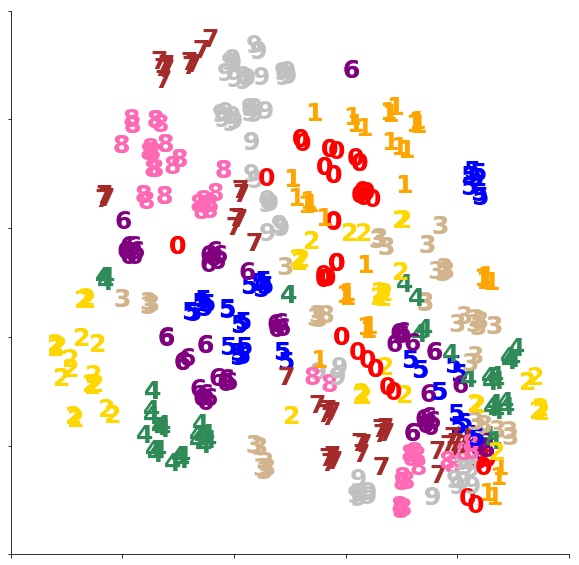

In [86]:
cluster_on(seq, syn_dis, fpath, 'mem', 3, 1, 1+1, 0, 2+1)

['1'] [] 1
['5'] [] 5
['6'] [] 6
['8'] [] 8
['7'] [] 7
[[ 7.644e-01  3.099e-01 -1.645e+00  6.810e-01 -5.130e-01  1.070e+00
  -5.541e-01 -7.028e-01 -2.531e-01  5.920e-01]
 [ 3.569e-06 -9.778e-07 -3.212e-06  1.692e-07 -2.256e-06 -3.170e-06
  -1.230e-07 -2.154e-06 -3.898e-07 -1.071e-06]
 [ 1.254e-04 -3.520e-05  7.860e-06  4.357e-05 -2.316e-05  4.410e-05
   3.301e-05 -5.712e-05 -7.108e-05 -1.278e-04]
 [ 3.655e-01  7.323e-01  2.596e-01 -7.838e-01  1.297e+00  6.822e-02
   1.328e-02  1.191e-01  7.763e-01  1.641e+00]
 [ 4.610e-08  2.547e-08 -9.443e-08  8.065e-09 -2.139e-08  2.614e-08
  -5.190e-08  2.346e-08 -1.516e-08  2.765e-08]]


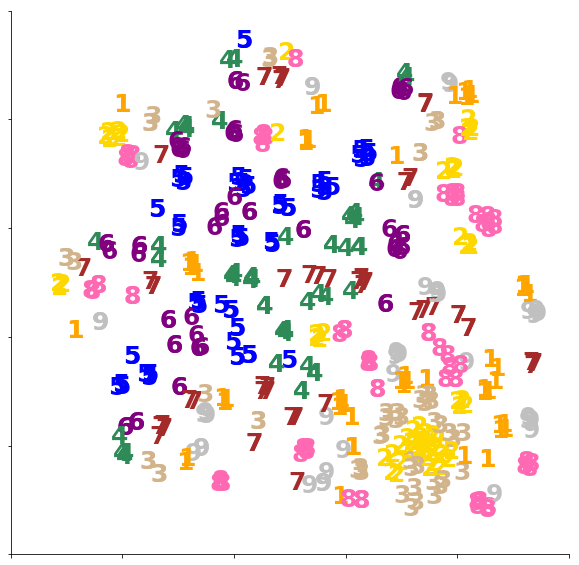

In [89]:
cluster_on(seq, syn_dis, fpath, 'mem', 3, 1, 1+1, 2, 2+1)

['1', '-', '1'] [1, 5] 0
['5', '-', '5'] [1, 5] 0
['8', '-', '6'] [1, 5] 2
['8', '+', '8'] [1, 5] 6
['3', '+', '7'] [1, 5] 0
[[ 0.764  0.31  -1.645  0.681 -0.513  1.07  -0.554 -0.703 -0.253  0.592]
 [ 1.558 -0.427 -1.402  0.074 -0.985 -1.384 -0.054 -0.94  -0.17  -0.468]
 [ 1.365 -0.383  0.086  0.475 -0.252  0.48   0.36  -0.622 -0.774 -1.392]
 [ 0.365  0.732  0.26  -0.784  1.297  0.068  0.013  0.119  0.776  1.641]
 [ 0.699  0.386 -1.431  0.122 -0.324  0.396 -0.787  0.356 -0.23   0.419]]


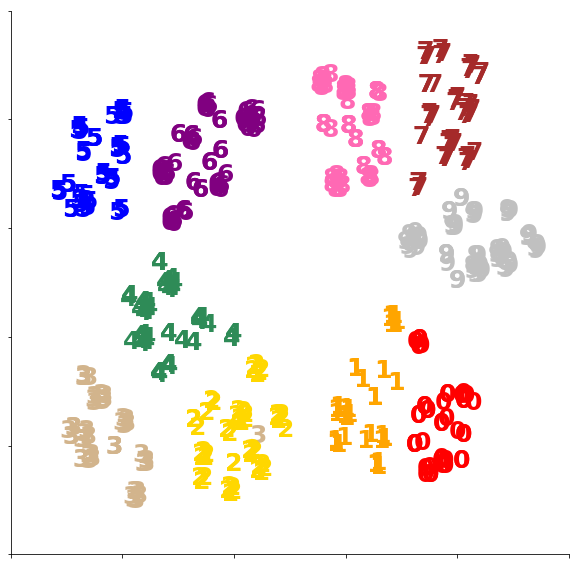

In [90]:
cluster_on(seq, syn_dis, fpath, 'mem', 2, 0, 0+1, 0, 2+1)

['1'] [] 1
['5'] [] 5
['6'] [] 6
['8'] [] 8
['7'] [] 7
[[ 7.644e-01  3.099e-01 -1.645e+00  6.810e-01 -5.130e-01  1.070e+00
  -5.541e-01 -7.028e-01 -2.531e-01  5.920e-01]
 [ 3.569e-06 -9.778e-07 -3.212e-06  1.692e-07 -2.256e-06 -3.170e-06
  -1.230e-07 -2.154e-06 -3.898e-07 -1.071e-06]
 [ 1.254e-04 -3.520e-05  7.860e-06  4.357e-05 -2.316e-05  4.410e-05
   3.301e-05 -5.712e-05 -7.108e-05 -1.278e-04]
 [ 3.655e-01  7.323e-01  2.596e-01 -7.838e-01  1.297e+00  6.822e-02
   1.328e-02  1.191e-01  7.763e-01  1.641e+00]
 [ 4.610e-08  2.547e-08 -9.443e-08  8.065e-09 -2.139e-08  2.614e-08
  -5.190e-08  2.346e-08 -1.516e-08  2.765e-08]]


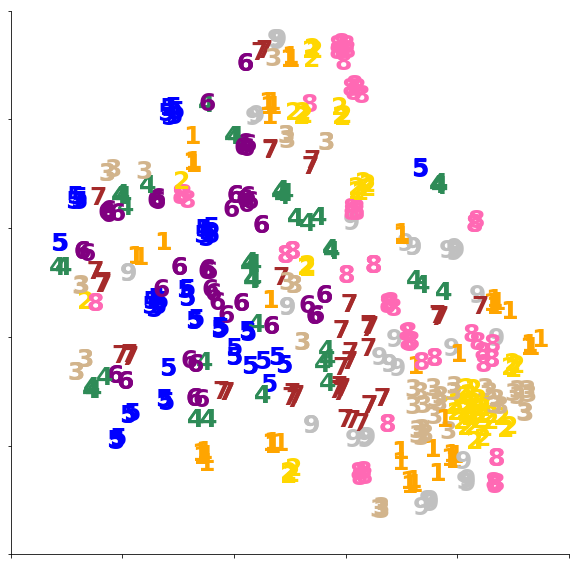

In [91]:
cluster_on(seq, syn_dis, fpath, 'mem', 3, 1, 1+1, 2, 2+1)

['1'] [] 1
['5'] [] 5
['6'] [] 6
['8'] [] 8
['7'] [] 7
[[ 2.177e-01  1.383e+00 -9.362e-01 -1.559e-01  2.361e-01 -2.378e-01
   5.444e-01 -2.093e+00 -1.933e+00  2.754e+00]
 [ 2.195e-04  5.397e-04 -8.789e-05 -2.468e-04 -7.118e-04 -5.214e-04
  -2.585e-04 -3.823e-04 -3.461e-04  1.107e-05]
 [-4.426e-04 -4.575e-04  1.508e-05  7.337e-04 -1.714e-04  5.493e-04
   7.984e-04  5.337e-04 -4.054e-04 -6.874e-04]
 [-2.342e-01  3.459e-01  6.360e-02 -2.722e-01  3.863e-01 -1.466e-01
  -3.102e+00 -4.546e-01  1.385e-01  1.584e+00]
 [-5.930e-04  3.171e-04  1.337e-04  4.818e-04  1.812e-04 -1.369e-04
   1.699e-04 -4.507e-04  3.529e-05 -6.845e-04]]


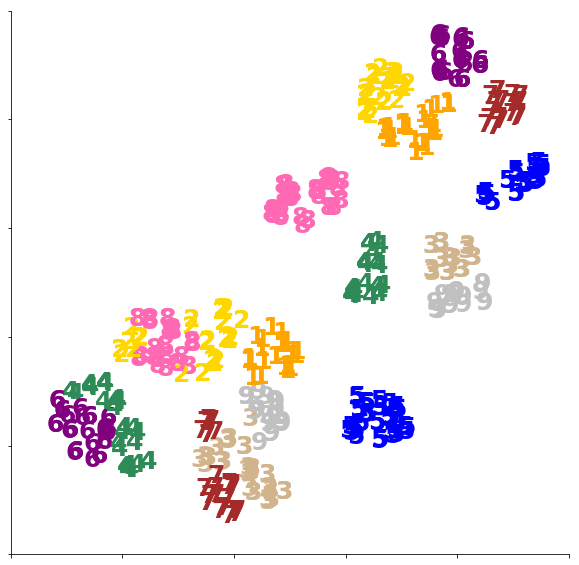

In [92]:
cluster_on(seq, syn_dis, fpath, 'mem', 3, 0, 0+1, 2, 2+1)

In [ ]:
cluster_on(seq, syn_dis, fpath, 'mem', 3, 1, 1+1, 0, 2+1)

In [87]:
p = np.array([3.8776e-05,  2.3806e-05,  2.6678e-01,  5.0629e-01,  6.1428e-05,
          3.5640e-06,  1.4418e-05,  1.6428e-06,  1.3094e-02,  8.1270e-03,
          4.0721e-04,  2.0516e-01])

# hid

In [107]:
def cluster_hid(seq, syn_dis, fpath, t, term_begin, term_end):
    seq_len = len(seq)
    print_num = 5
    printed = 0
    vals = []
    exprs = []
    i = 0
    nc = 0
    nt = 0
    hids = {t:[] for t in range(seq_len)}
    
    colors = {
        '0': 'r',
        '1': 'orange',
        '2': 'gold',
        '3': 'tan',
        '4': 'seagreen',
        '5': 'b',
        '6': 'purple',
        '7': 'brown',
        '8': 'hotpink',
        '9': 'silver',
        '*': 'orange',
        '/': 'orchid',
        '+': 'orange',
        '-': 'orchid',}
    
    with open(fpath, 'r') as f:
        for line in f:
            line_json = json.loads(line)
            if line_json['type'] != 'actions':
                assert line_json['type'] == 'input'
                nc += line_json['is_correct']
                nt += 1
                
                node_lst = line_json['expr'][term_begin: term_end]
                ds = syn_dis[term_begin: term_end-1]
                exprs.append(line_json['expr'])
                try:
                    eval(''.join(node_lst))
                    val = to_value_sd(ds, node_lst)[1] if len(node_lst) > 1 else node_lst[0]
                except:
                    val = ''.join(node_lst)
                
                if printed < print_num:
                    print(node_lst, ds, val)
                    printed += 1
                
                vals.append(val)
                continue 
            hids[i].append(line_json['hid'])        
            i += 1
            i %= seq_len

    X = np.array([hids[t][i] for i in range(len(hids[t]))])
    print(X[:printed, :10])
    
    X_embedded = TSNE(n_components=2).fit_transform(X)
    x_min, x_max = X_embedded.min(0) - 5, X_embedded.max(0) + 5 
    X_norm = (X_embedded - x_min) / (x_max - x_min)  # 归一化
    plt.figure(figsize=(10, 10))
    for i in range(X_norm.shape[0]):
        if vals[i] in colors:
            plt.text(X_norm[i, 0], X_norm[i, 1], str(vals[i]), color=colors[str(vals[i])], 
                     fontdict={'weight': 'bold', 'size': 25})
        else:
            plt.text(X_norm[i, 0], X_norm[i, 1], str(vals[i]),
                 fontdict={'weight': 'bold', 'size': 25})
    ax = plt.gca() # 获取当前的axes
    ax.spines['top'].set_visible(False) #去掉右边框
    ax.spines['right'].set_visible(False) #去掉右边框
    plt.xticks(np.arange(0,1.2,0.2), [])
    plt.yticks(np.arange(0,1.2,0.2), [])
    plt.show()

['1'] [] 1
['5'] [] 5
['8'] [] 8
['8'] [] 8
['3'] [] 3
[[-1.927e-05 -4.100e-02 -2.554e-03 -3.346e-01 -1.607e-04 -1.716e-05
   2.036e-01  2.812e-02  8.508e-02  1.887e-03]
 [ 5.983e-02 -1.015e-01 -2.525e-05 -6.013e-03 -3.218e-01  5.310e-04
   1.313e-01  3.221e-01  1.688e-02  2.524e-02]
 [-8.414e-03 -5.576e-01 -1.538e-05 -3.803e-03  4.613e-03 -1.998e-03
   1.526e-03  3.553e-01  3.416e-03  3.119e-01]
 [-8.414e-03 -5.576e-01 -1.538e-05 -3.803e-03  4.613e-03 -1.998e-03
   1.526e-03  3.553e-01  3.416e-03  3.119e-01]
 [ 4.969e-05 -2.988e-02 -2.705e-05 -2.387e-01  3.404e-03 -1.588e-02
   8.224e-03  3.901e-02  5.506e-03  5.939e-01]]


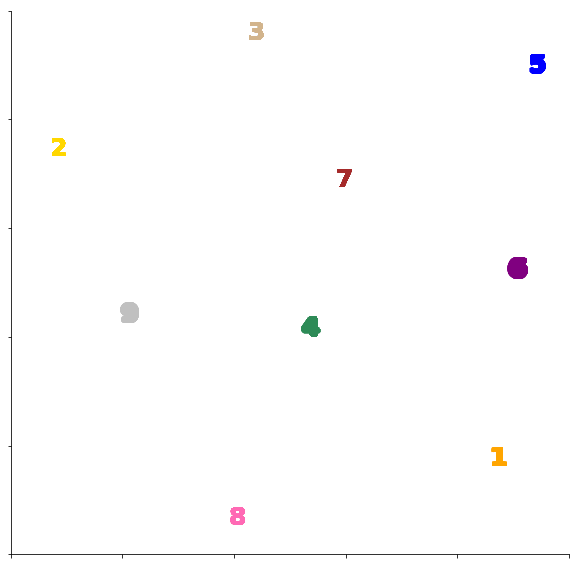

In [95]:
fpath = 'feval-analy_d23_ne10-sarnn-1544191300.txt'
cluster_hid(seq, syn_dis, fpath, 0, 0, 0+1)

['-'] [] -
['-'] [] -
['-'] [] -
['+'] [] +
['+'] [] +
[[ 7.555e-08  7.586e-08  7.615e-01  7.616e-01 -1.927e-03 -2.594e-13
  -2.596e-03  2.470e-05 -7.584e-01  7.476e-02]
 [ 1.095e-04  2.663e-06  2.900e-03 -7.520e-01 -5.440e-07  1.990e-05
   7.601e-01 -8.798e-07 -7.597e-01 -7.611e-01]
 [-5.796e-10  2.076e-04  7.616e-01  7.614e-01  7.585e-01 -1.153e-06
  -7.470e-01  3.335e-08  7.616e-01 -7.588e-01]
 [-3.858e-08  1.252e-04  7.490e-01  4.507e-03  7.601e-01 -3.164e-05
  -7.466e-01  5.017e-01  7.616e-01 -7.550e-01]
 [ 1.552e-02  1.020e-07 -2.251e-01  7.612e-01  4.802e-02  4.861e-14
  -7.615e-01 -7.610e-01 -7.615e-01  7.616e-01]]


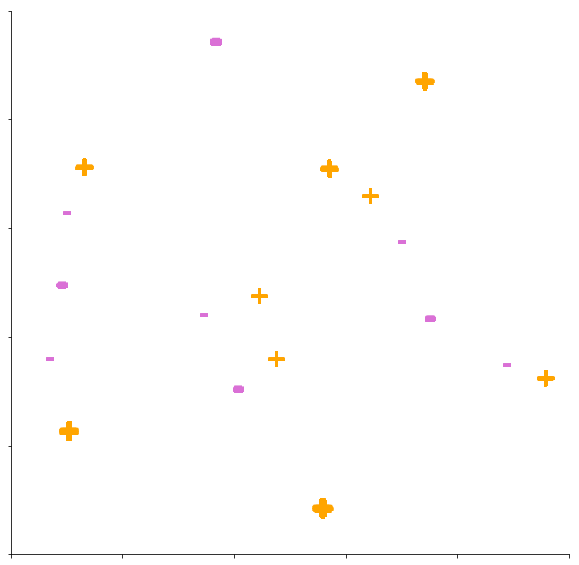

In [98]:
cluster_hid(seq, syn_dis, fpath, 1, 1, 1+1)

['1'] [] 1
['5'] [] 5
['8'] [] 8
['8'] [] 8
['3'] [] 3
[[ 7.555e-08  7.586e-08  7.615e-01  7.616e-01 -1.927e-03 -2.594e-13
  -2.596e-03  2.470e-05 -7.584e-01  7.476e-02]
 [ 1.095e-04  2.663e-06  2.900e-03 -7.520e-01 -5.440e-07  1.990e-05
   7.601e-01 -8.798e-07 -7.597e-01 -7.611e-01]
 [-5.796e-10  2.076e-04  7.616e-01  7.614e-01  7.585e-01 -1.153e-06
  -7.470e-01  3.335e-08  7.616e-01 -7.588e-01]
 [-3.858e-08  1.252e-04  7.490e-01  4.507e-03  7.601e-01 -3.164e-05
  -7.466e-01  5.017e-01  7.616e-01 -7.550e-01]
 [ 1.552e-02  1.020e-07 -2.251e-01  7.612e-01  4.802e-02  4.861e-14
  -7.615e-01 -7.610e-01 -7.615e-01  7.616e-01]]


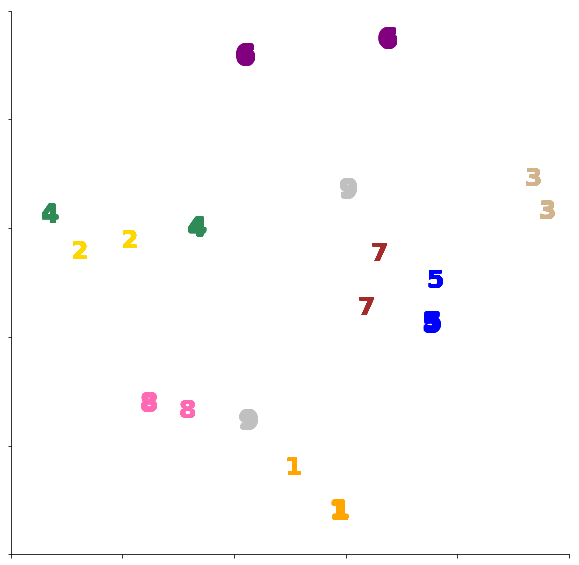

In [101]:
cluster_hid(seq, syn_dis, fpath, 1, 0, 0+1)

['1', '-'] [1] 1-
['5', '-'] [1] 5-
['8', '-'] [1] 8-
['8', '+'] [1] 8+
['3', '+'] [1] 3+
[[ 7.555e-08  7.586e-08  7.615e-01  7.616e-01 -1.927e-03 -2.594e-13
  -2.596e-03  2.470e-05 -7.584e-01  7.476e-02]
 [ 1.095e-04  2.663e-06  2.900e-03 -7.520e-01 -5.440e-07  1.990e-05
   7.601e-01 -8.798e-07 -7.597e-01 -7.611e-01]
 [-5.796e-10  2.076e-04  7.616e-01  7.614e-01  7.585e-01 -1.153e-06
  -7.470e-01  3.335e-08  7.616e-01 -7.588e-01]
 [-3.858e-08  1.252e-04  7.490e-01  4.507e-03  7.601e-01 -3.164e-05
  -7.466e-01  5.017e-01  7.616e-01 -7.550e-01]
 [ 1.552e-02  1.020e-07 -2.251e-01  7.612e-01  4.802e-02  4.861e-14
  -7.615e-01 -7.610e-01 -7.615e-01  7.616e-01]]


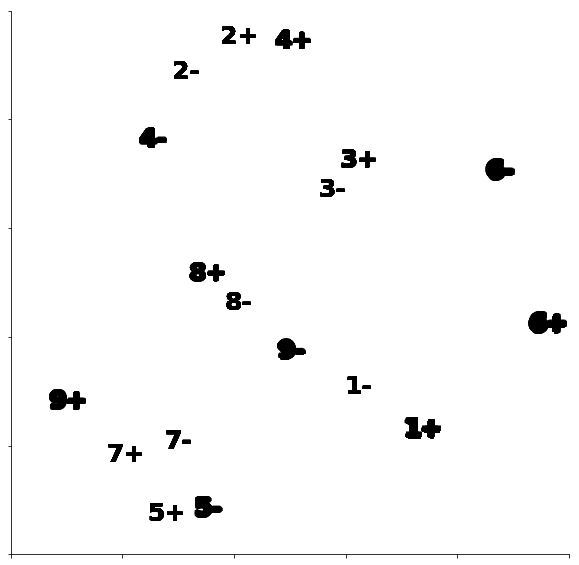

In [108]:
cluster_hid(seq, syn_dis, fpath, 1, 0, 1+1)

In [74]:
plt.cm.hot(0.3)

(0.8240081481370484, 0.0, 0.0, 1.0)

<BarContainer object of 5 artists>

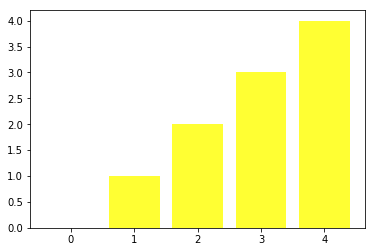

In [88]:
plt.bar(np.arange(5), np.arange(5), color=plt.cm.Set1(0.6))

['1', '-', '1'] [1, 5] 0
['5', '-', '5'] [1, 5] 0
['8', '-', '6'] [1, 5] 2
['8', '+', '8'] [1, 5] 6
['3', '+', '7'] [1, 5] 0
[[ 4.269e-03  5.663e-02  3.375e-01  6.008e-01  4.279e-05  4.138e-05
   9.906e-03  1.767e-03 -6.729e-01  2.845e-02]
 [ 1.135e-02  1.941e-01  2.501e-05 -3.450e-03 -3.211e-02  1.135e-03
   5.075e-02 -5.397e-03 -7.571e-03  2.913e-03]
 [ 1.143e-01 -5.971e-01 -1.908e-01  1.454e-03 -1.395e-03  2.670e-03
  -6.863e-02 -3.045e-02  1.588e-01  3.950e-04]
 [-5.572e-05 -6.148e-01  7.537e-04  1.525e-03 -1.521e-02 -2.612e-03
  -6.855e-04 -9.655e-02  3.165e-01  1.470e-02]
 [ 5.015e-02  2.351e-01 -1.295e-02 -8.158e-04 -5.152e-05  2.926e-05
  -7.195e-02 -2.398e-04 -5.673e-01  4.849e-02]]


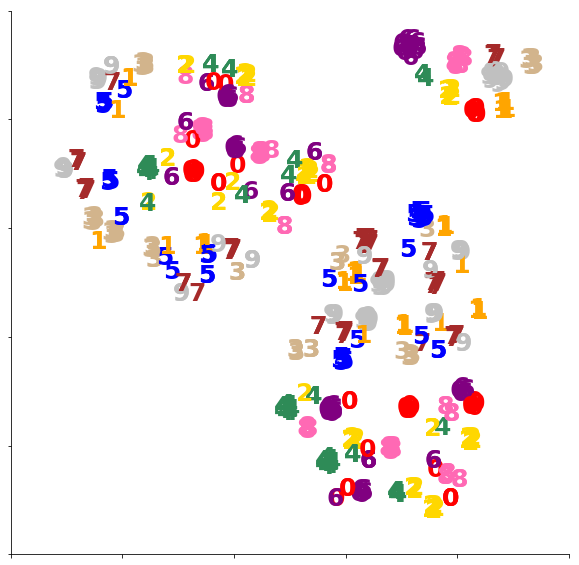

In [99]:
cluster_hid(seq, syn_dis, fpath, 2, 0, 2+1)

['/'] [] /
['*'] [] *
['*'] [] *
['/'] [] /
['*'] [] *
[[ 8.584e-09  9.625e-01  1.289e-03  4.216e-06 -2.535e-08  4.185e-02
   1.013e-02  5.016e-01 -7.075e-01  4.501e-03]
 [ 8.252e-01  9.630e-01  1.511e-02 -1.454e-01 -5.747e-01  9.314e-01
   1.360e-01 -9.635e-01 -2.585e-01  2.380e-11]
 [-7.542e-01 -7.609e-01 -1.588e-04  1.873e-03 -7.304e-01  8.533e-01
  -2.906e-01 -1.727e-01  9.545e-01  8.355e-08]
 [-2.593e-15 -7.568e-01  6.682e-14  4.223e-07 -5.634e-05 -8.457e-04
  -1.147e-01 -3.922e-04  9.611e-01  5.243e-01]
 [ 8.370e-01  9.633e-01 -2.694e-06 -2.274e-02 -7.585e-01  7.701e-01
  -9.576e-01 -5.263e-01 -9.617e-01  1.918e-07]]


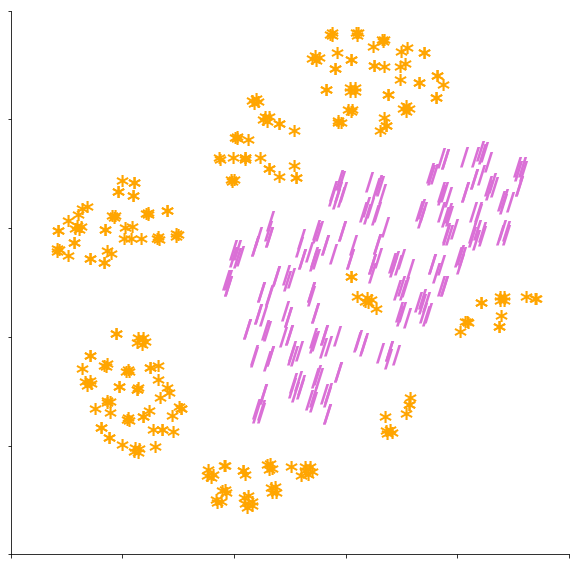

In [100]:
cluster_hid(seq, syn_dis, fpath, 3, 3, 3+1)

# pushed

In [28]:
def cluster_pushed(seq, syn_dis, fpath, t, term_begin, term_end):
    seq_len = len(seq)
    print_num = 5
    printed = 0
    vals = []
    exprs = []
    i = 0
    nc = 0
    nt = 0
    pusheds = {t:[] for t in range(seq_len)}
    
    colors = {
        '0': 'r',
        '1': 'orange',
        '2': 'gold',
        '3': 'tan',
        '4': 'seagreen',
        '5': 'b',
        '6': 'purple',
        '7': 'brown',
        '8': 'hotpink',
        '9': 'silver',
        '*': 'orange',
        '/': 'orchid',
        '+': 'orange',
        '-': 'orchid',}
    
    with open(fpath, 'r') as f:
        for line in f:
            line_json = json.loads(line)
            if line_json['type'] != 'actions':
                assert line_json['type'] == 'input'
                nc += line_json['is_correct']
                nt += 1
                
                node_lst = line_json['expr'][term_begin: term_end]
                ds = syn_dis[term_begin: term_end-1]
                exprs.append(line_json['expr'])
                val = to_value_sd(ds, node_lst)[1] if len(node_lst) > 1 else node_lst[0]
                
                if printed < print_num:
                    print(node_lst, ds, val)
                    printed += 1
                
                vals.append(val)
                continue 
            pusheds[i].append(line_json['pushed'])        
            i += 1
            i %= seq_len

    X = np.array([pusheds[t][i] for i in range(len(pusheds[t]))])
    print(X[:printed, :10])
    
    X_embedded = TSNE(n_components=2).fit_transform(X)
    x_min, x_max = X_embedded.min(0) - 5, X_embedded.max(0) + 5 
    X_norm = (X_embedded - x_min) / (x_max - x_min)  # 归一化
    plt.figure(figsize=(10, 10))
    for i in range(X_norm.shape[0]):
        if vals[i] in colors:
            plt.text(X_norm[i, 0], X_norm[i, 1], str(vals[i]), color=colors[str(vals[i])], 
                     fontdict={'weight': 'bold', 'size': 25})
        else:
            plt.text(X_norm[i, 0], X_norm[i, 1], str(vals[i]),
                 fontdict={'weight': 'bold', 'size': 25})
    ax = plt.gca() # 获取当前的axes
    ax.spines['top'].set_visible(False) #去掉右边框
    ax.spines['right'].set_visible(False) #去掉右边框
    plt.xticks(np.arange(0,1.2,0.2), [])
    plt.yticks(np.arange(0,1.2,0.2), [])
    plt.show()

In [29]:
seq = '8 + 6 * 3 / 2 - 4 * 7 * 4 / 5 - 1 / 5 / 4 * 9 / 9 + 1 + 8 * 4 - 7 * 9 * 9 + 3 / 4 + 7 / 9 - 6 / 6 * 4 + 3 / 3'.split(' ')
ds = '1 5 1 2 3 4 6 7 1 2 3 4 5 6 8 9 1 2 3 4 5 6 7 8 10 11 12 13 1 2 14 15 1 2 3 4 16 17 1 2 18 19 1 2 20 21 1 2 3 4 22 23 1 2'.split(' ')
syn_dis = [int(d) for d in ds]

['1'] [] 1
['5'] [] 5
['8'] [] 8
['8'] [] 8
['3'] [] 3
[[ 0.118  1.532 -0.522  1.002 -0.424 -0.306 -0.332 -0.932 -1.231 -0.708]
 [ 0.614  1.454  0.565 -1.662  2.06  -1.437  0.194 -1.345  1.386 -0.868]
 [ 0.795  0.129 -1.172  0.979 -0.264 -0.279  0.658  0.58  -0.45   0.673]
 [ 0.795  0.129 -1.172  0.979 -0.264 -0.279  0.658  0.58  -0.45   0.673]
 [-0.613  0.029  1.739 -0.024  0.56  -1.098  1.046 -0.199 -1.39  -1.83 ]]


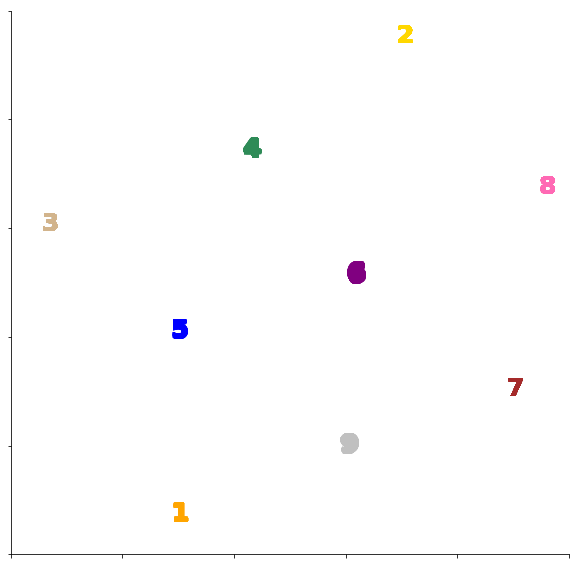

In [30]:
fpath='feval-analy_d23_ne10-sarnn-1544193152.txt'
cluster_pushed(seq, syn_dis, fpath, 0, 0, 0+1)

['-'] [] -
['-'] [] -
['-'] [] -
['+'] [] +
['+'] [] +
[[ 1.917  0.989 -1.995  0.243 -1.742  1.668 -1.777  0.863 -1.604  0.533]
 [ 1.845  1.669  0.102 -1.975  0.529 -2.09   0.126 -1.013  0.73   1.08 ]
 [ 0.716  1.116 -0.497  0.45   0.128  0.402 -0.018 -1.541 -0.466  0.432]
 [ 0.053  0.365 -0.978 -0.094 -1.812  2.088 -0.542 -2.194 -1.555 -0.934]
 [ 2.48   0.52   0.027  0.513  0.656 -1.808  0.63  -1.296  0.051  3.845]]


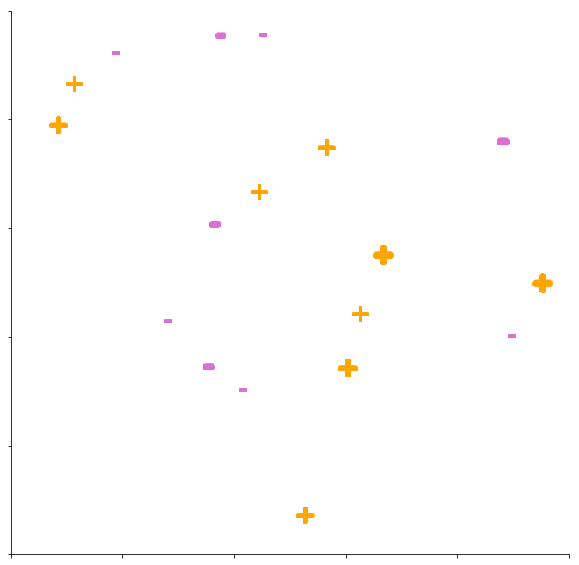

In [31]:
cluster_pushed(seq, syn_dis, fpath, 1, 1, 1+1)

['1', '-', '1'] [1, 5] 0
['5', '-', '5'] [1, 5] 0
['8', '-', '6'] [1, 5] 2
['8', '+', '8'] [1, 5] 6
['3', '+', '7'] [1, 5] 0
[[ 0.989  0.401 -2.128  0.881 -0.664  1.384 -0.717 -0.909 -0.327  0.766]
 [ 1.834 -0.503 -1.651  0.087 -1.16  -1.629 -0.063 -1.107 -0.2   -0.55 ]
 [ 1.793 -0.503  0.112  0.623 -0.331  0.631  0.472 -0.817 -1.017 -1.828]
 [ 0.375  0.752  0.267 -0.805  1.332  0.07   0.014  0.122  0.797  1.684]
 [ 0.798  0.441 -1.635  0.14  -0.37   0.453 -0.899  0.406 -0.262  0.479]]


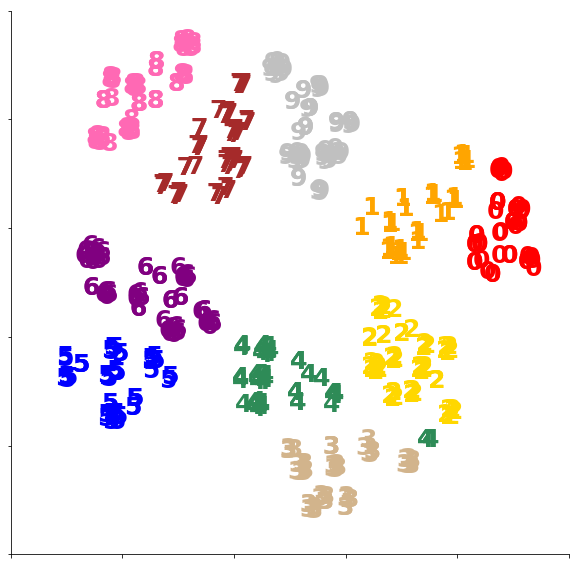

In [32]:
cluster_pushed(seq, syn_dis, fpath, 2, 0, 2+1)

['/'] [] /
['*'] [] *
['*'] [] *
['/'] [] /
['*'] [] *
[[ 0.218  1.383 -0.936 -0.156  0.236 -0.238  0.544 -2.093 -1.933  2.754]
 [ 0.946  2.355 -0.373 -1.076 -3.095 -2.263 -1.126 -1.66  -1.507  0.051]
 [-1.388 -1.434  0.047  2.3   -0.537  1.722  2.503  1.674 -1.271 -2.155]
 [-0.234  0.346  0.064 -0.272  0.386 -0.147 -3.102 -0.455  0.138  1.584]
 [-2.61   1.395  0.588  2.12   0.797 -0.603  0.748 -1.983  0.155 -3.012]]


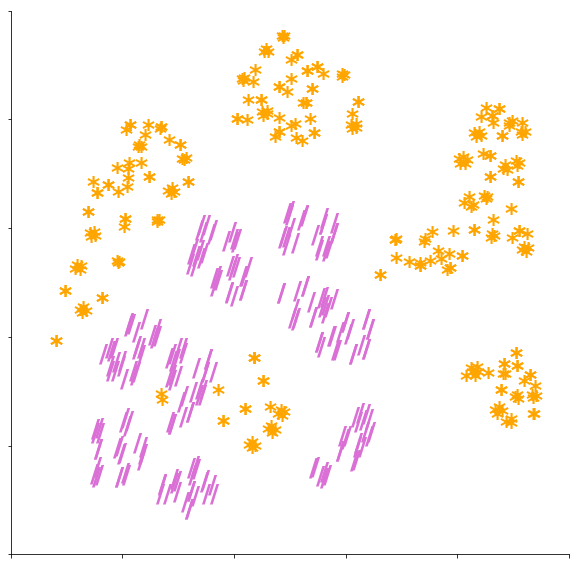

In [33]:
cluster_pushed(seq, syn_dis, fpath, 3, 3, 3+1)

['1', '-', '1', '/', '1'] [1, 5, 1, 2] 1
['5', '-', '5', '*', '6'] [1, 5, 1, 2] 5
['8', '-', '6', '*', '5'] [1, 5, 1, 2] 8
['8', '+', '8', '/', '1'] [1, 5, 1, 2] 8
['3', '+', '7', '*', '9'] [1, 5, 1, 2] 6
[[ 1.871  0.972 -1.56   0.271 -1.727 -0.885 -0.078 -1.437 -0.815  1.483]
 [ 0.763  1.378  0.643 -1.892 -0.133 -1.357 -0.763 -1.081 -0.267  1.535]
 [ 1.206 -0.19  -0.225 -0.094 -0.46  -1.012 -0.045 -0.294  0.163  2.166]
 [ 2.04   0.1   -1.064  0.207 -2.437 -0.267  0.216 -1.379  0.733  0.708]
 [-0.339 -0.789  0.119  0.601  1.259 -0.634  0.776  0.779  0.227  0.766]]


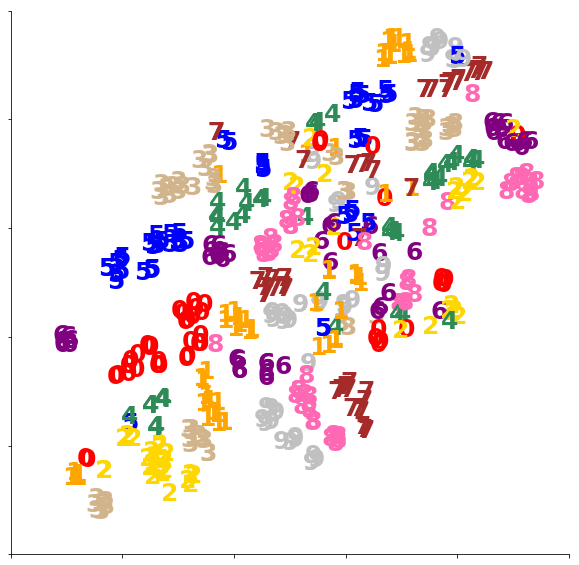

In [36]:
cluster_pushed(seq, syn_dis, fpath, 4, 0, 4+1)

['*'] [] *
['/'] [] /
['*'] [] *
['*'] [] *
['*'] [] *
[[ 2.176  1.132 -1.893  0.362 -1.709 -0.359 -1.523  0.205 -1.204  0.802]
 [ 1.167  0.283 -0.367 -0.977 -0.96  -2.601 -0.446 -0.779 -0.816  2.671]
 [ 0.982 -0.885 -0.176  0.641 -0.362  0.474  0.476 -0.458  0.822  0.497]
 [ 0.972 -0.578 -1.195  0.316 -2.084  0.248  0.281 -0.136  0.639  0.724]
 [ 0.156  1.979  1.385  0.432  2.285 -0.282 -0.296 -0.346  1.065 -2.744]]


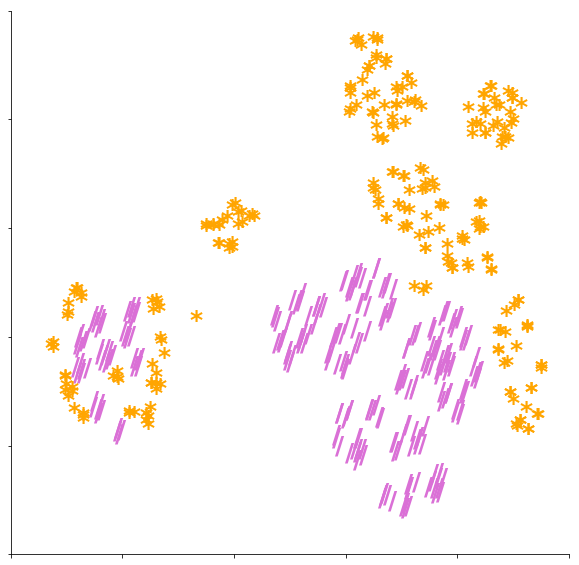

In [37]:
cluster_pushed(seq, syn_dis, fpath, 5, 5, 5+1)

['1', '-', '1', '/', '1', '*', '9'] [1, 5, 1, 2, 3, 4] 1
['5', '-', '5', '*', '6', '/', '6'] [1, 5, 1, 2, 3, 4] 5
['8', '-', '6', '*', '5', '*', '6'] [1, 5, 1, 2, 3, 4] 8
['8', '+', '8', '/', '1', '*', '8'] [1, 5, 1, 2, 3, 4] 8
['3', '+', '7', '*', '9', '*', '9'] [1, 5, 1, 2, 3, 4] 0
[[ 1.009e+00  6.618e-01 -5.601e-01  9.843e-01 -9.614e-01  4.001e-01
  -2.434e-01 -5.336e-01 -9.701e-01  3.728e-01]
 [ 1.079e+00  1.019e+00  5.783e-01 -1.053e+00 -1.210e+00 -1.801e+00
   2.489e-01 -1.801e+00  5.238e-01  1.423e-01]
 [ 9.051e-01 -5.463e-01 -3.554e-01  5.066e-01 -1.357e+00 -4.748e-01
   1.033e-01 -1.845e-01  4.872e-02  2.292e+00]
 [ 8.434e-01 -4.722e-01  2.973e-01  9.803e-04 -5.681e-01 -3.806e-01
   2.271e-01  1.425e-01  4.629e-01  1.403e+00]
 [-3.435e-01 -5.423e-01 -1.554e+00  1.706e+00 -5.612e-01  8.347e-01
  -5.148e-01  1.986e+00 -1.031e+00  2.613e-01]]


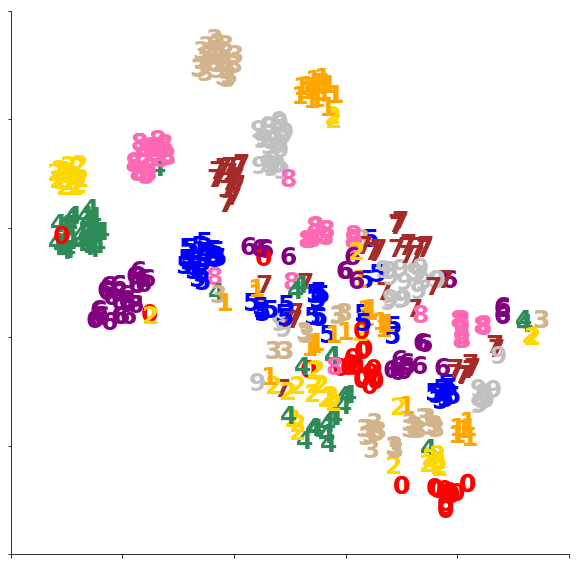

In [38]:
cluster_pushed(seq, syn_dis, fpath, 6, 0, 6+1)